<a href="https://colab.research.google.com/github/HandyGunawan17/Portfolio_Management/blob/main/Paper_Replication/Markov_Switching_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import warnings

!pip install arviz 
!pip install arviz --upgrade
!pip install pymc3 --upgrade
# !pip install --upgrade pandas

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from datetime import date
import copy


!pip install statsmodels --upgrade
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

     |████████████████████████████████| 1.6MB 7.6MB/s 
     |████████████████████████████████| 4.7MB 37.8MB/s 
     |████████████████████████████████| 808kB 42.5MB/s 
     |████████████████████████████████| 317kB 42.5MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
Requirement already up-to-date: arviz in /usr/local/lib/python3.7/dist-packages (0.11.2)
     |████████████████████████████████| 870kB 6.5MB/s 
     |████████████████████████████████| 1.8MB 25.3MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-cp37-none-any.whl size=1529948 sha256=7df0fd8e961f23ab32e6fe941affe55d5000d89d83ef8eab9b12591eb55d30dd
  Stored in directory: /root/.cache/pip/wheels/bd/5a/32/a5690ce4309abc60e1776ad3d3b408ead6da77ccced26ee723
Successfully built theano-pymc
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 9.5M

Running on PyMC3 v3.11.2
Running on ArviZ v0.11.2


The first code of the series of Markov Switching autoregressive model.

This code studies and replicate statsmodel Markov Switching (MS) Autoregressive (AR) model.

It Consists of Markov Switching Model, Markov Regression and finally Markov_auto Regression

 # First, we do the Markov Switching.

In [ ]:
# Regime_Analysis_Function

def Regime(Stock_Code, Start_Date,End_Date=date.today()):

  """
  Functions to download stocks data based on yahoo ticker
  and run statsmodel markov autoregression with 250 days triangular moving average
  The function resulting in adj close stocks data with regime analysis of bullish/bearish and high/low variance
  With Plot and summaries in between

  Input:
    Stock_Code = Yahoo Ticker
    Start_Date = Earliest stock date to be analyzed
    End_Date = Latest stock date to be analyzed, default today.
  """
  from pandas_datareader import data
  Stock_Data = data.DataReader(Stock_Code, 'yahoo', Start_Date,End_Date)
  Close = Stock_Data['Adj Close'].dropna()
  Close_Return = (np.log(Close) - np.log(Close.shift(1))).dropna()
  plt.figure(figsize=(15,5))
  plt.plot(Close)
  mod_kns = sm.tsa.MarkovRegression(Close_Return.dropna(), k_regimes=2, trend='nc', switching_variance=True)
  res_kns = mod_kns.fit()
  print(res_kns.summary())

  fig, axes = plt.subplots(2, figsize=(10,7))
  ax = axes[0]
  ax.plot(res_kns.smoothed_marginal_probabilities[0])
  ax.set(title='Smoothed probability of a low-variance regime for stock returns')
  ax = axes[1]
  ax.plot(res_kns.smoothed_marginal_probabilities[1])
  ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
  plt.show()
  Close_Data_Plot = Close[1:].to_frame()
  Close_Data_Plot['States'] = np.round(res_kns.smoothed_marginal_probabilities[0])
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.lineplot(x='Date',y='Adj Close',data=Close_Data_Plot,color="green")
  sns.scatterplot(x='Date',y='Adj Close',data=Close_Data_Plot[Close_Data_Plot['States']==0],color="red")
  plt.show()
  Close_Data_Plot = Close[1:].to_frame()
  TMA = Close_Data_Plot.rolling(250).mean().rolling(250).mean()
  Close_Data_Plot['States'] = np.ceil(Close_Data_Plot/TMA-1)
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.lineplot(x='Date',y='Adj Close',data=Close_Data_Plot,color="green")
  sns.scatterplot(x='Date',y='Adj Close',data=Close_Data_Plot[Close_Data_Plot['States']==0],color="red")
  Close.rolling(250).mean().rolling(250).mean().plot()
  plt.show()

  # Final Regime Visualization
  Close_Data_Plot['States_Variance'] = np.round(res_kns.smoothed_marginal_probabilities[0])
  Close_Data_Plot = Close_Data_Plot.dropna()
  Close_Data_Plot['Regime'] = 1
  Close_Data_Plot.loc[(Close_Data_Plot['States'] ==0) & (Close_Data_Plot['States_Variance'] ==0) ,'Regime'] = 1
  Close_Data_Plot.loc[(Close_Data_Plot['States'] ==1) & (Close_Data_Plot['States_Variance'] ==0) ,'Regime'] = 2
  Close_Data_Plot.loc[(Close_Data_Plot['States'] ==0) & (Close_Data_Plot['States_Variance'] ==1) ,'Regime'] = 3
  Close_Data_Plot.loc[(Close_Data_Plot['States'] ==1) & (Close_Data_Plot['States_Variance'] ==1) ,'Regime'] = 4
  sns.lineplot(x='Date',y='Adj Close',data=Close_Data_Plot,color="green")
  sns.scatterplot(x='Date',y='Adj Close',data=Close_Data_Plot[Close_Data_Plot['Regime']==1],color="red",label = "Bearish and High Var")
  sns.scatterplot(x='Date',y='Adj Close',data=Close_Data_Plot[Close_Data_Plot['Regime']==2],color="Yellow",label = "Bullish and High Var")
  sns.scatterplot(x='Date',y='Adj Close',data=Close_Data_Plot[Close_Data_Plot['Regime']==3],color="Orange",label = "Bearish and Low Var")
  sns.scatterplot(x='Date',y='Adj Close',data=Close_Data_Plot[Close_Data_Plot['Regime']==4],color="Blue",label = "Bullish and Low Var")
  plt.show()
  # Further Analysis

  Close_Data_Plot['Adj Close Return'] = np.log(Close_Data_Plot['Adj Close']/Close_Data_Plot['Adj Close'].shift())
  
  print(Close_Data_Plot.groupby('Regime').mean()['Adj Close Return'])
  print(Close_Data_Plot.groupby('Regime').std()['Adj Close Return'])
  print(Close_Data_Plot.groupby('Regime').count()['Adj Close Return'])

  Close_Data_Plot[Close_Data_Plot['Regime']==1]['Adj Close Return'].hist()
  plt.show()
  Close_Data_Plot[Close_Data_Plot['Regime']==2]['Adj Close Return'].hist()
  plt.show()
  Close_Data_Plot[Close_Data_Plot['Regime']==3]['Adj Close Return'].hist()
  plt.show()
  Close_Data_Plot[Close_Data_Plot['Regime']==4]['Adj Close Return'].hist()
  plt.show()

  Close_Data_Plot = Close_Data_Plot.merge(Stock_Data[['High','Low','Close','Open']],how='left', on='Date')
  
  return Close_Data_Plot



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:              Adj Close   No. Observations:                 5372
Model:               MarkovRegression   Log Likelihood               17096.584
Date:                Wed, 12 May 2021   AIC                         -34185.168
Time:                        12:28:31   BIC                         -34158.812
Sample:                             0   HQIC                        -34175.964
                               - 5372                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.965e-05   1.67e-06     29.683      0.000    4.64e-05    5.29e-05
                             Regime 1 parameters    

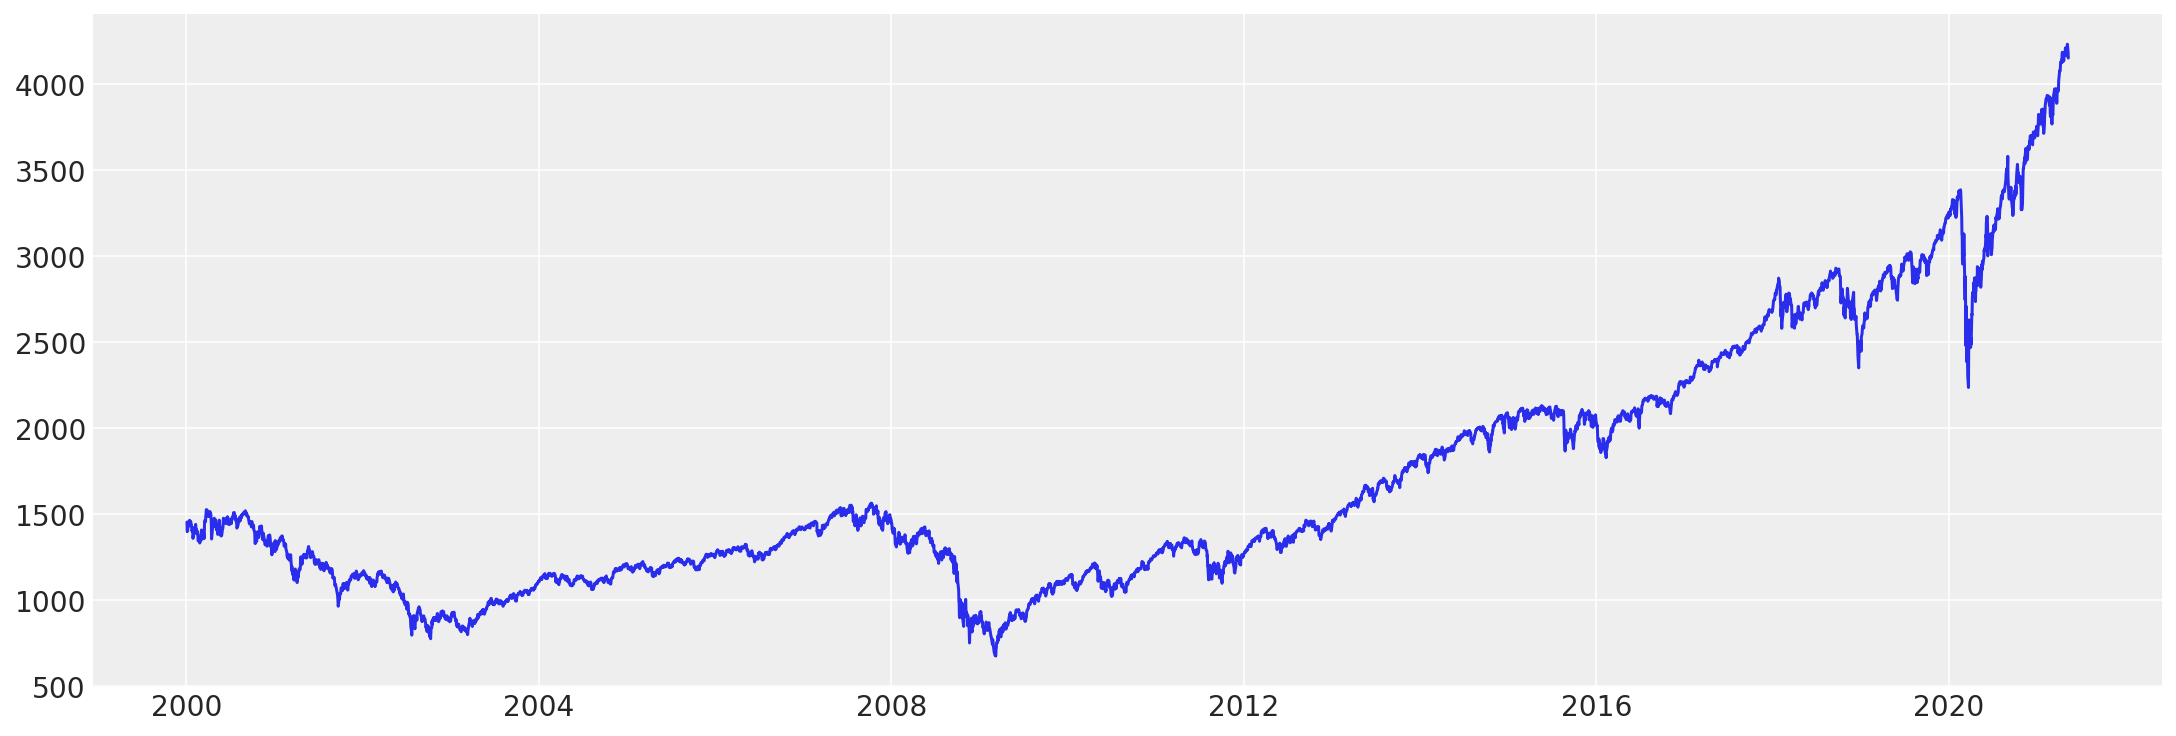

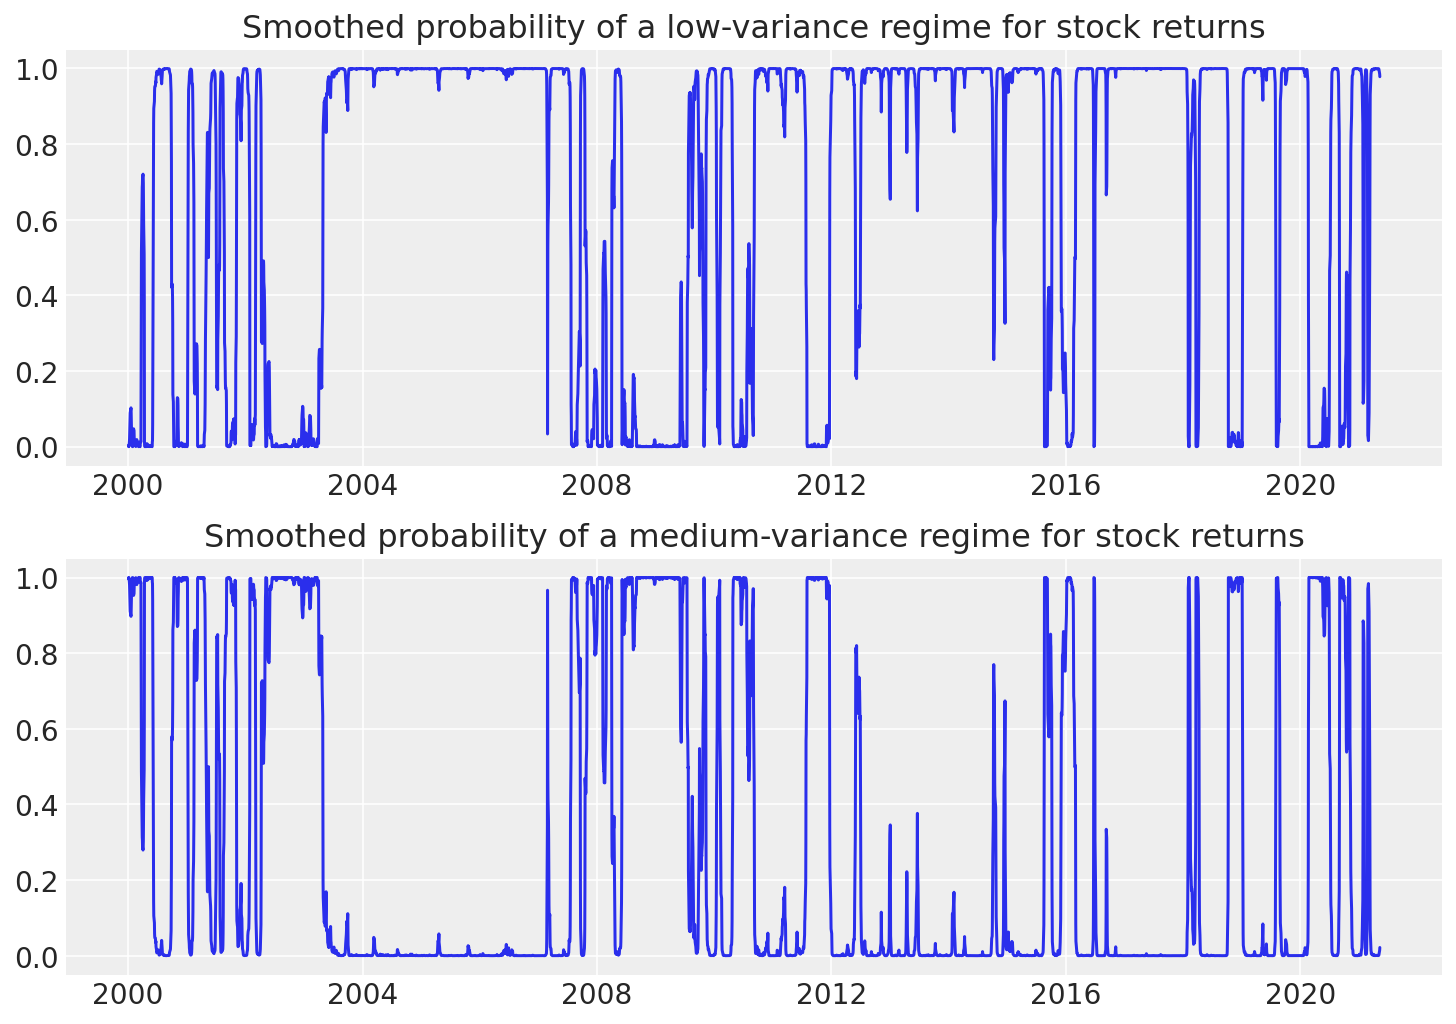

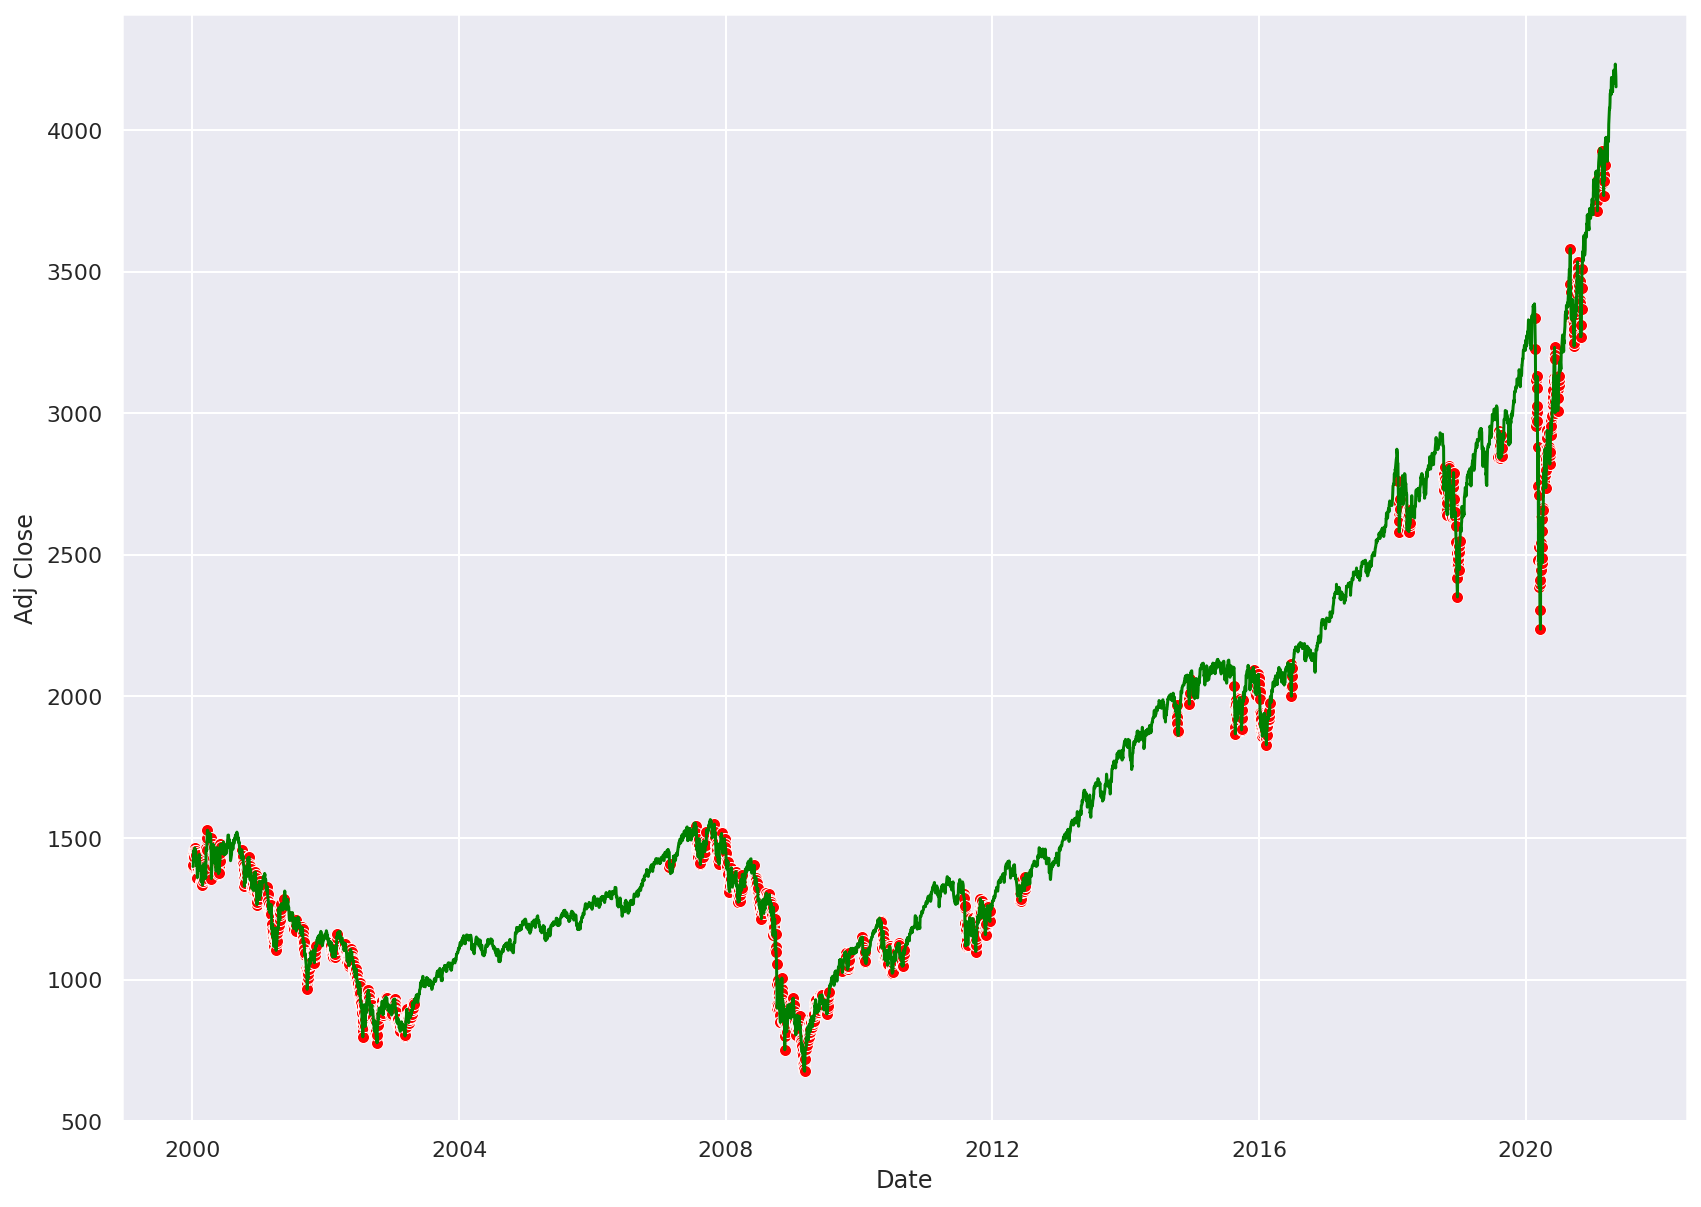

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(bottom=0.2)


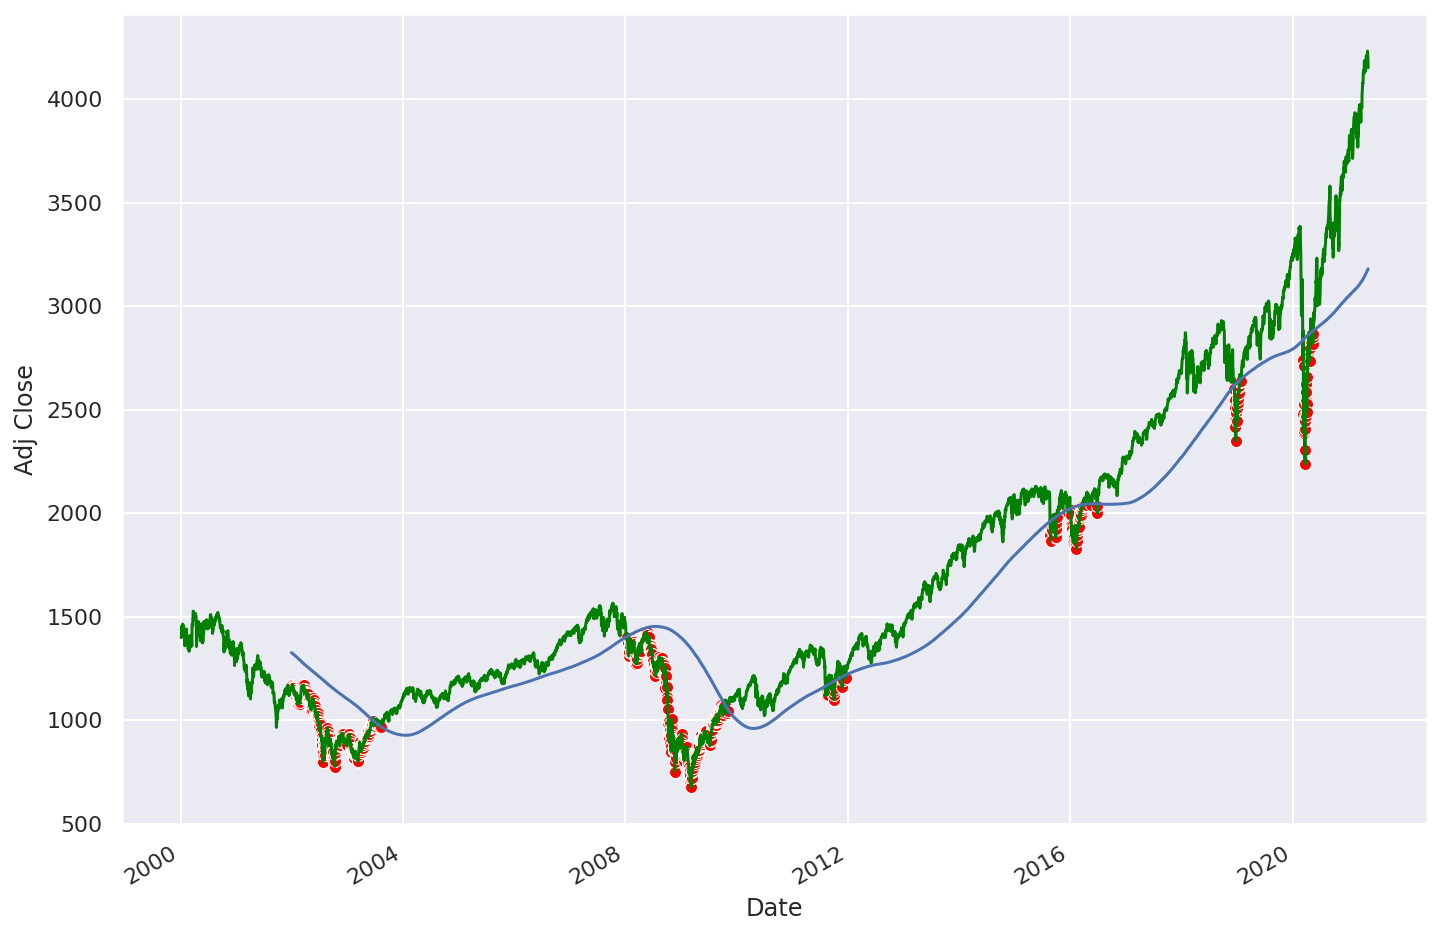

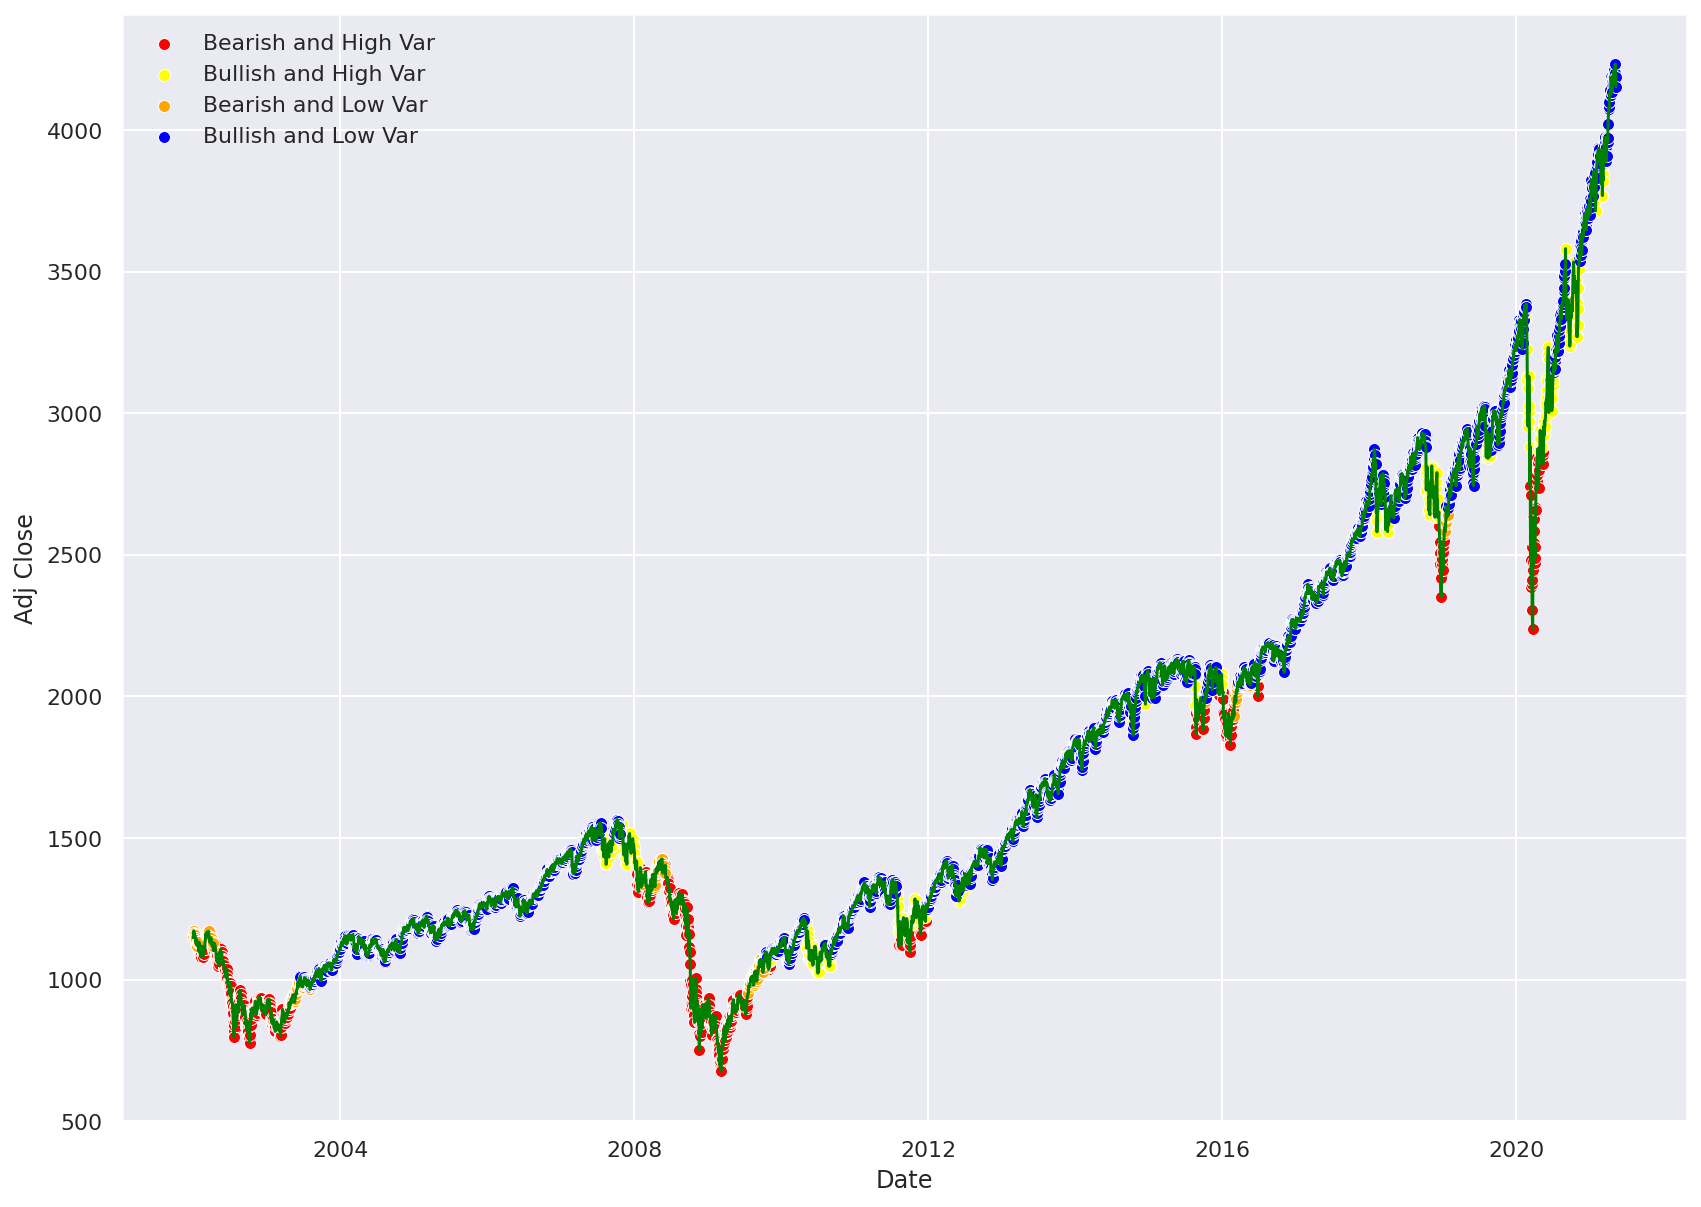

Regime
1   -0.001701
2    0.000047
3    0.000579
4    0.000741
Name: Adj Close Return, dtype: float64
Regime
1    0.023499
2    0.016253
3    0.008686
4    0.006711
Name: Adj Close Return, dtype: float64
Regime
1     785
2     535
3     232
4    3321
Name: Adj Close Return, dtype: int64


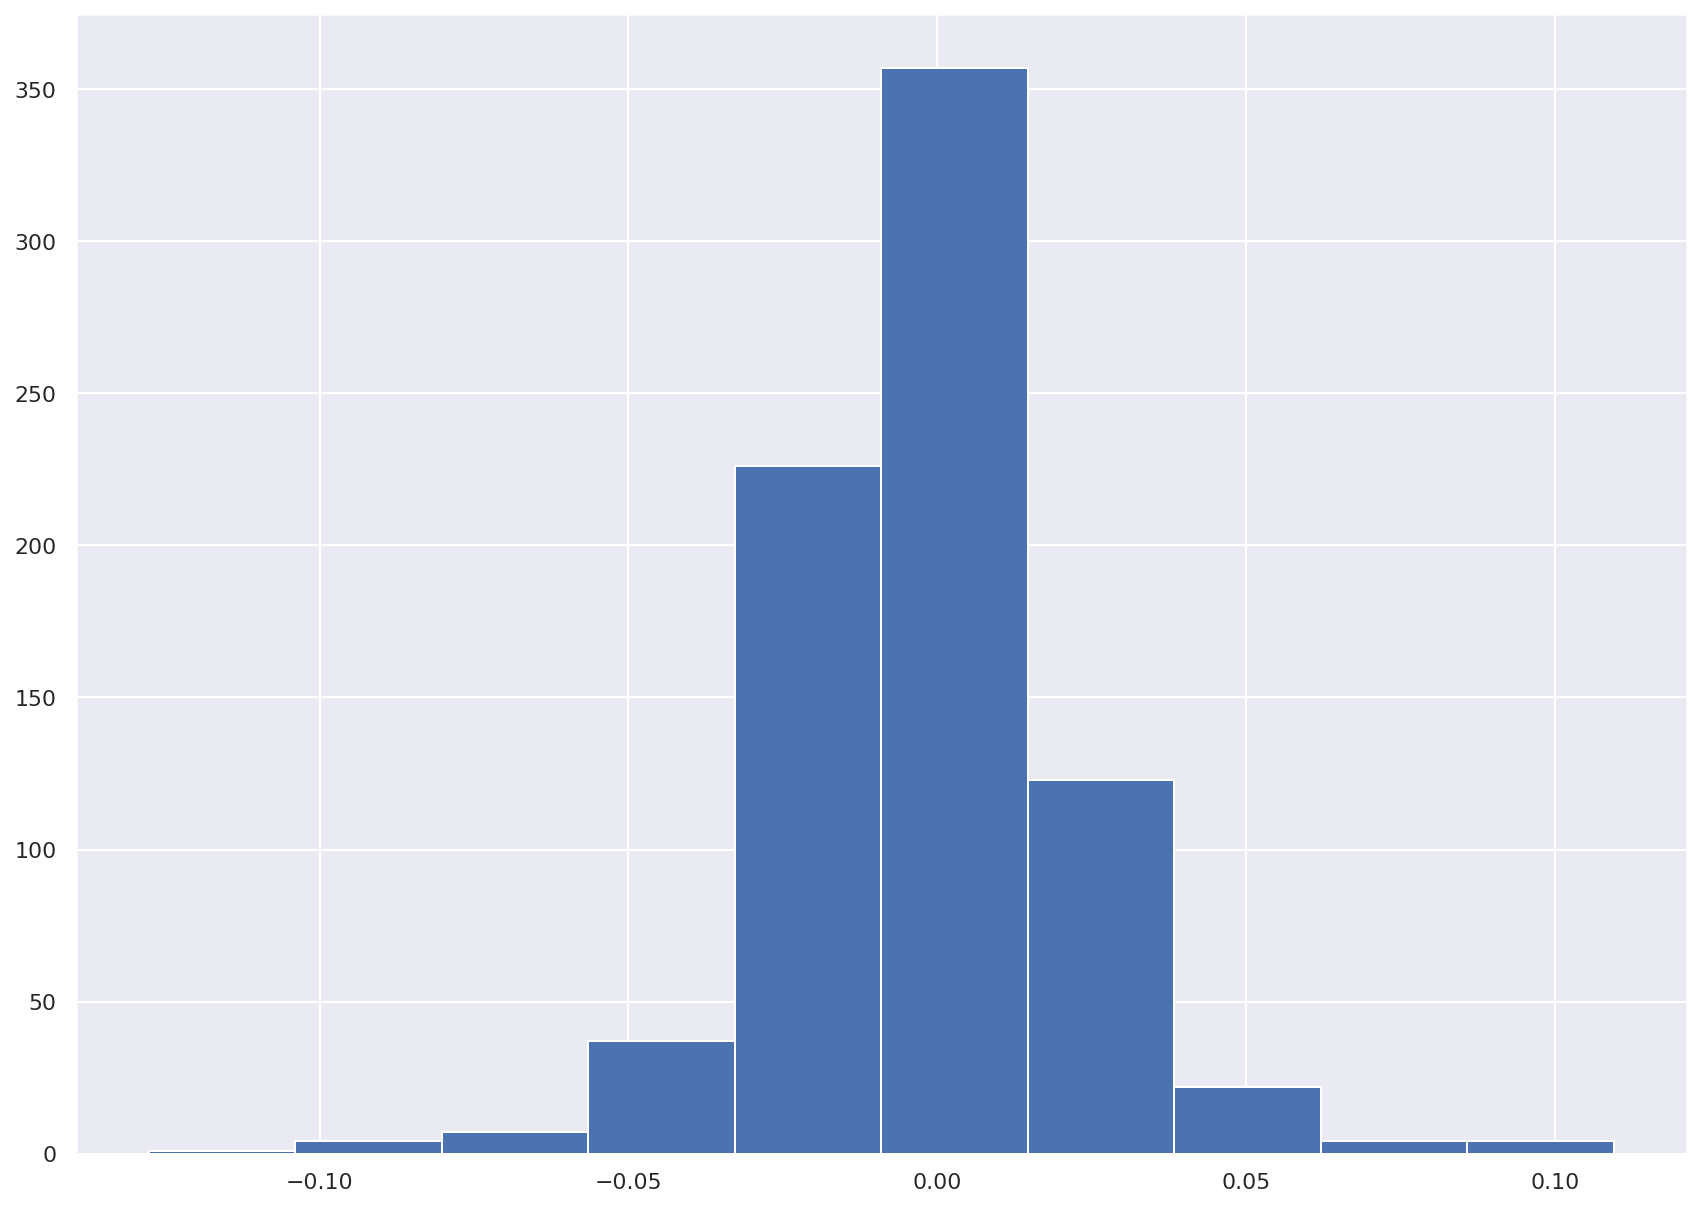

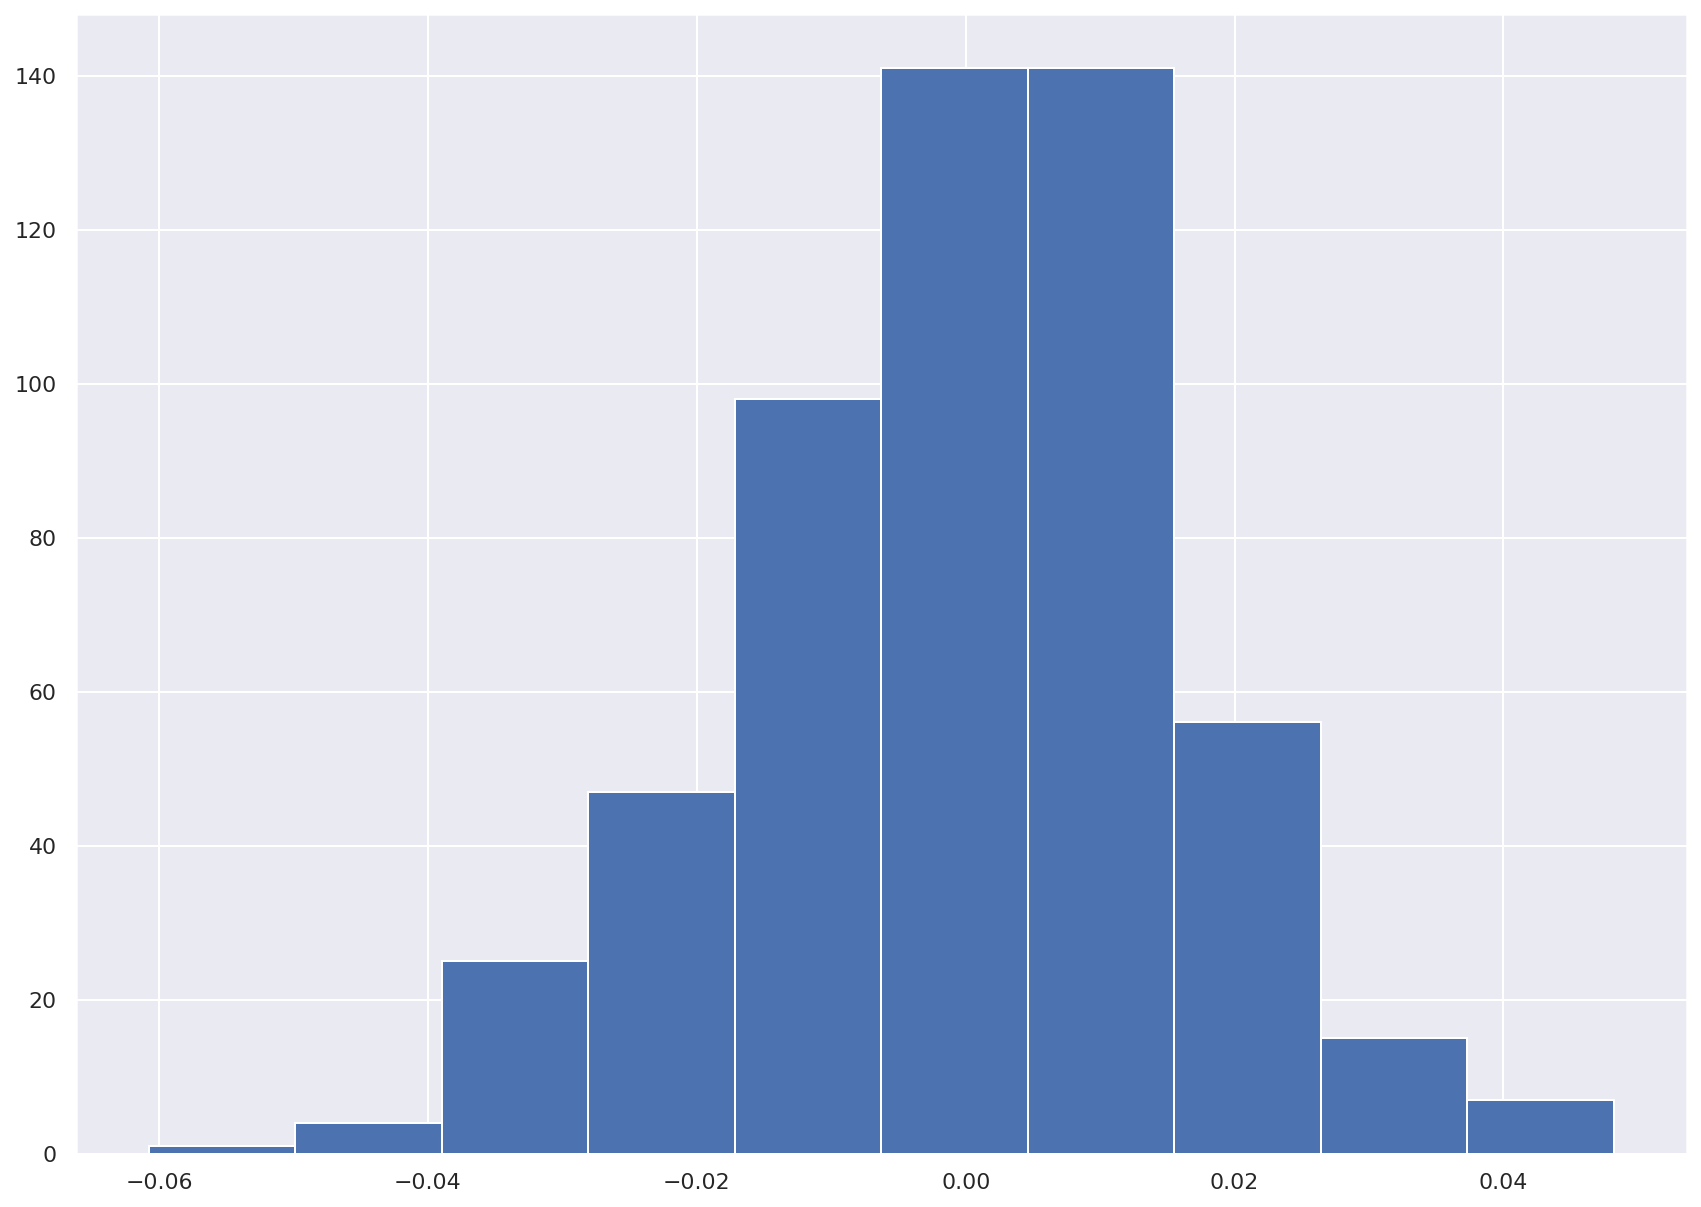

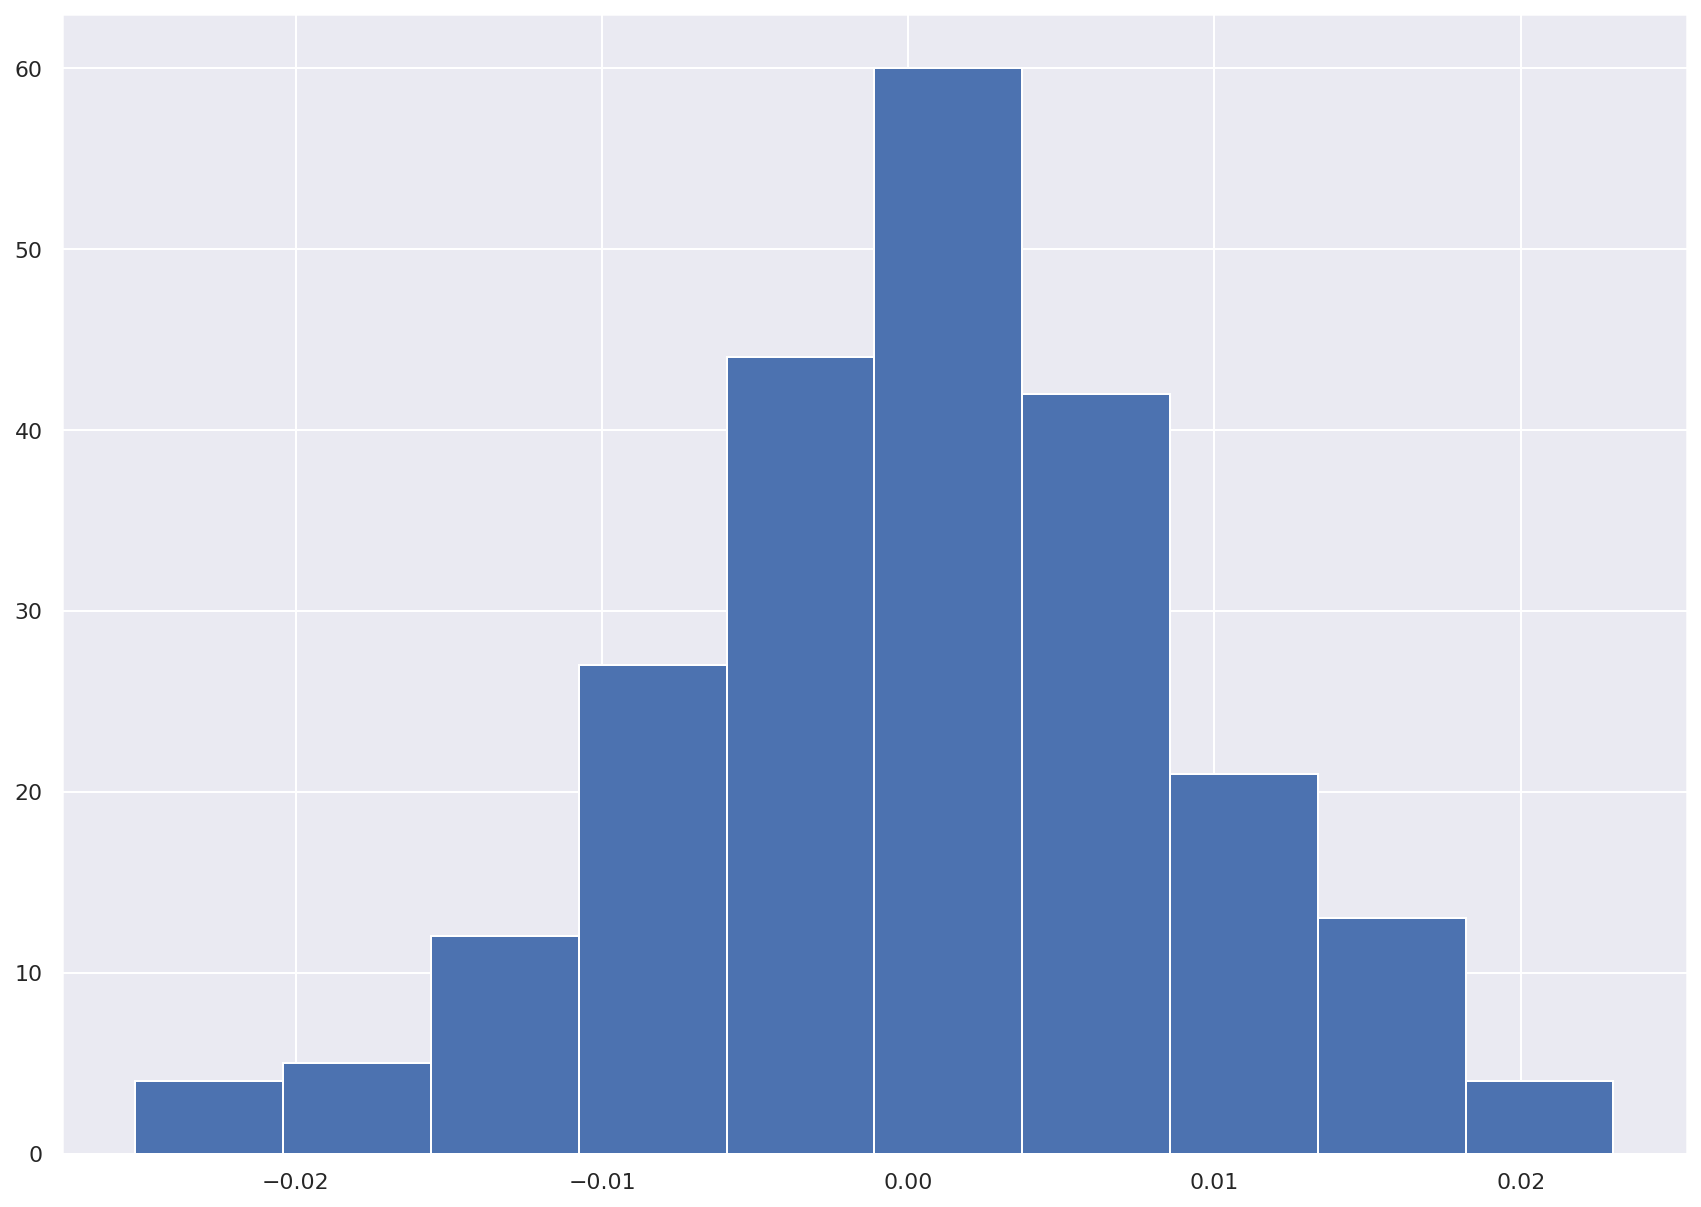

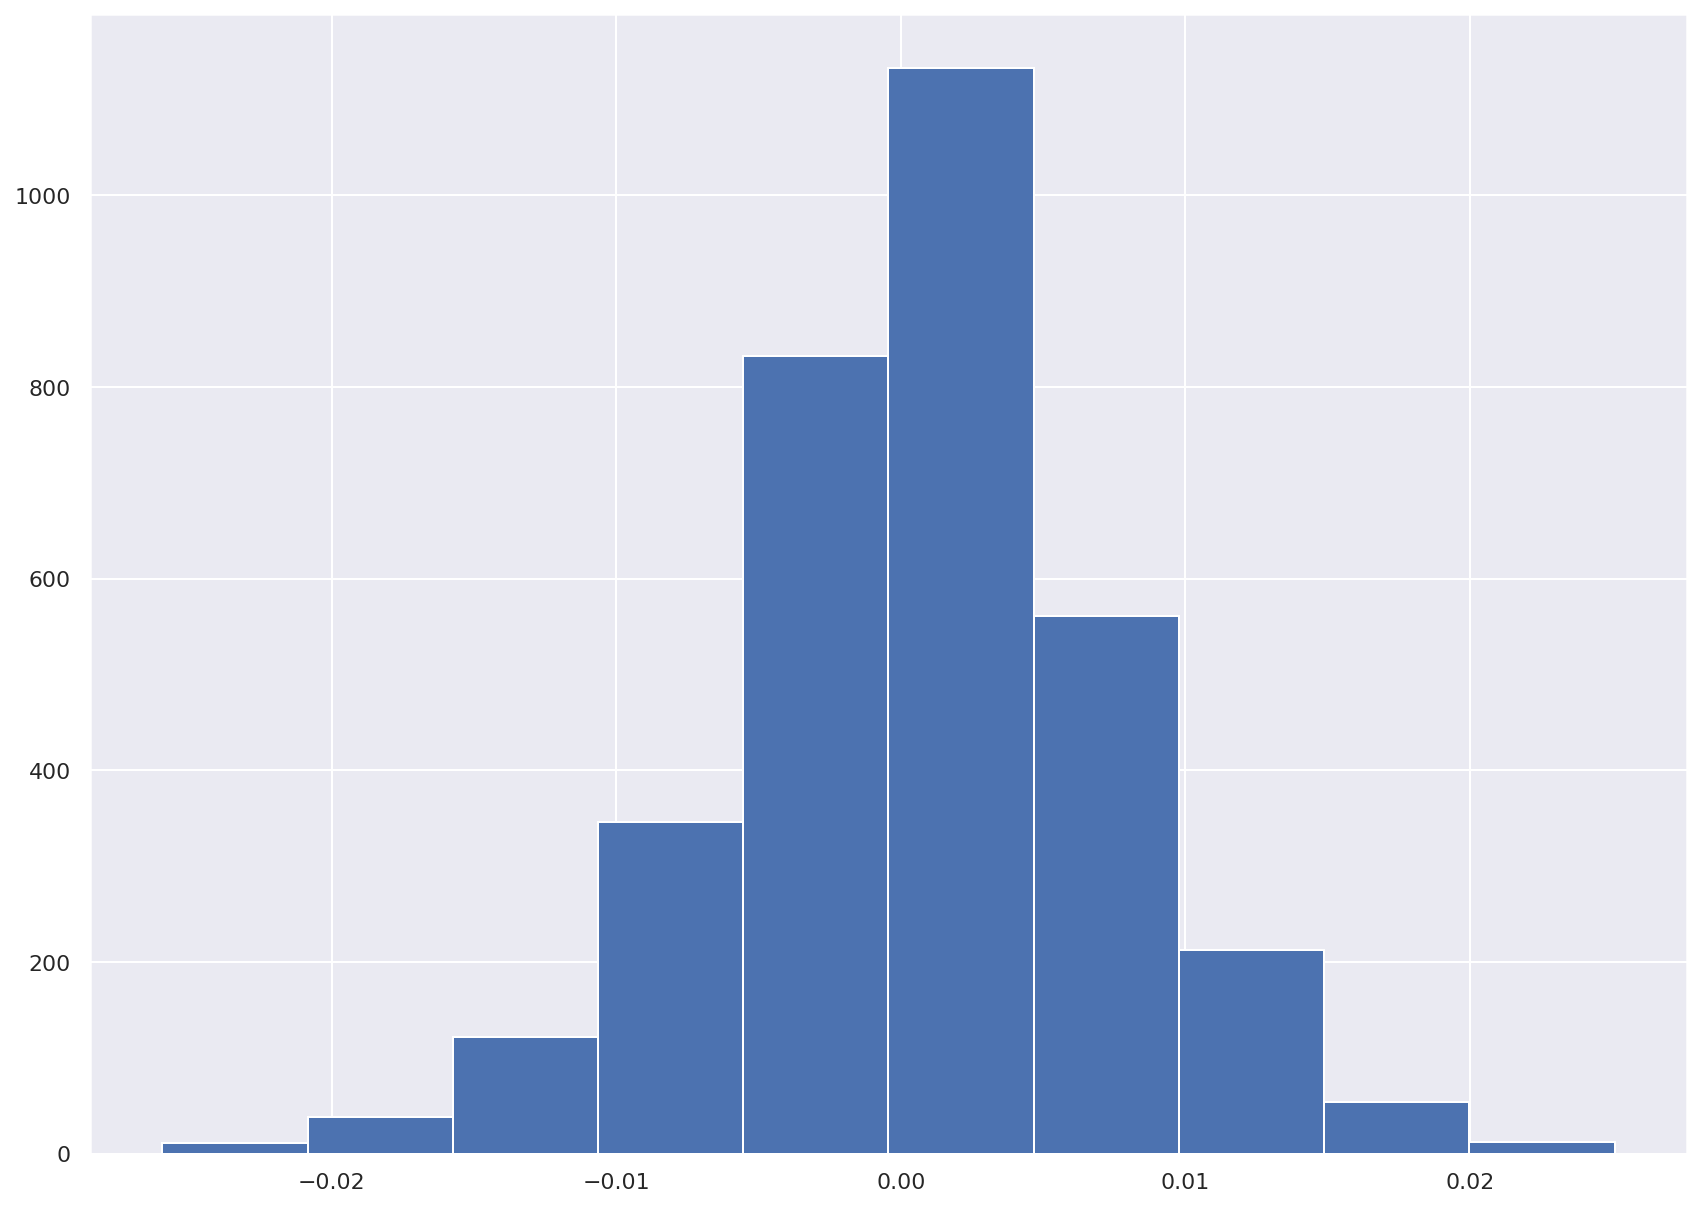

In [ ]:
start_date = '2000-01-01'
# User pandas_reader.data.DataReader to load the desired data. As simple as that.
# S_P = data.DataReader('^GSPC', 'yahoo', start_date)
S_P = Regime('^GSPC', start_date)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:              Adj Close   No. Observations:                 5193
Model:               MarkovRegression   Log Likelihood               15755.137
Date:                Wed, 12 May 2021   AIC                         -31502.275
Time:                        12:28:45   BIC                         -31476.054
Sample:                             0   HQIC                        -31493.102
                               - 5193                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.576e-05   3.01e-06     25.184      0.000    6.99e-05    8.17e-05
                             Regime 1 parameters    

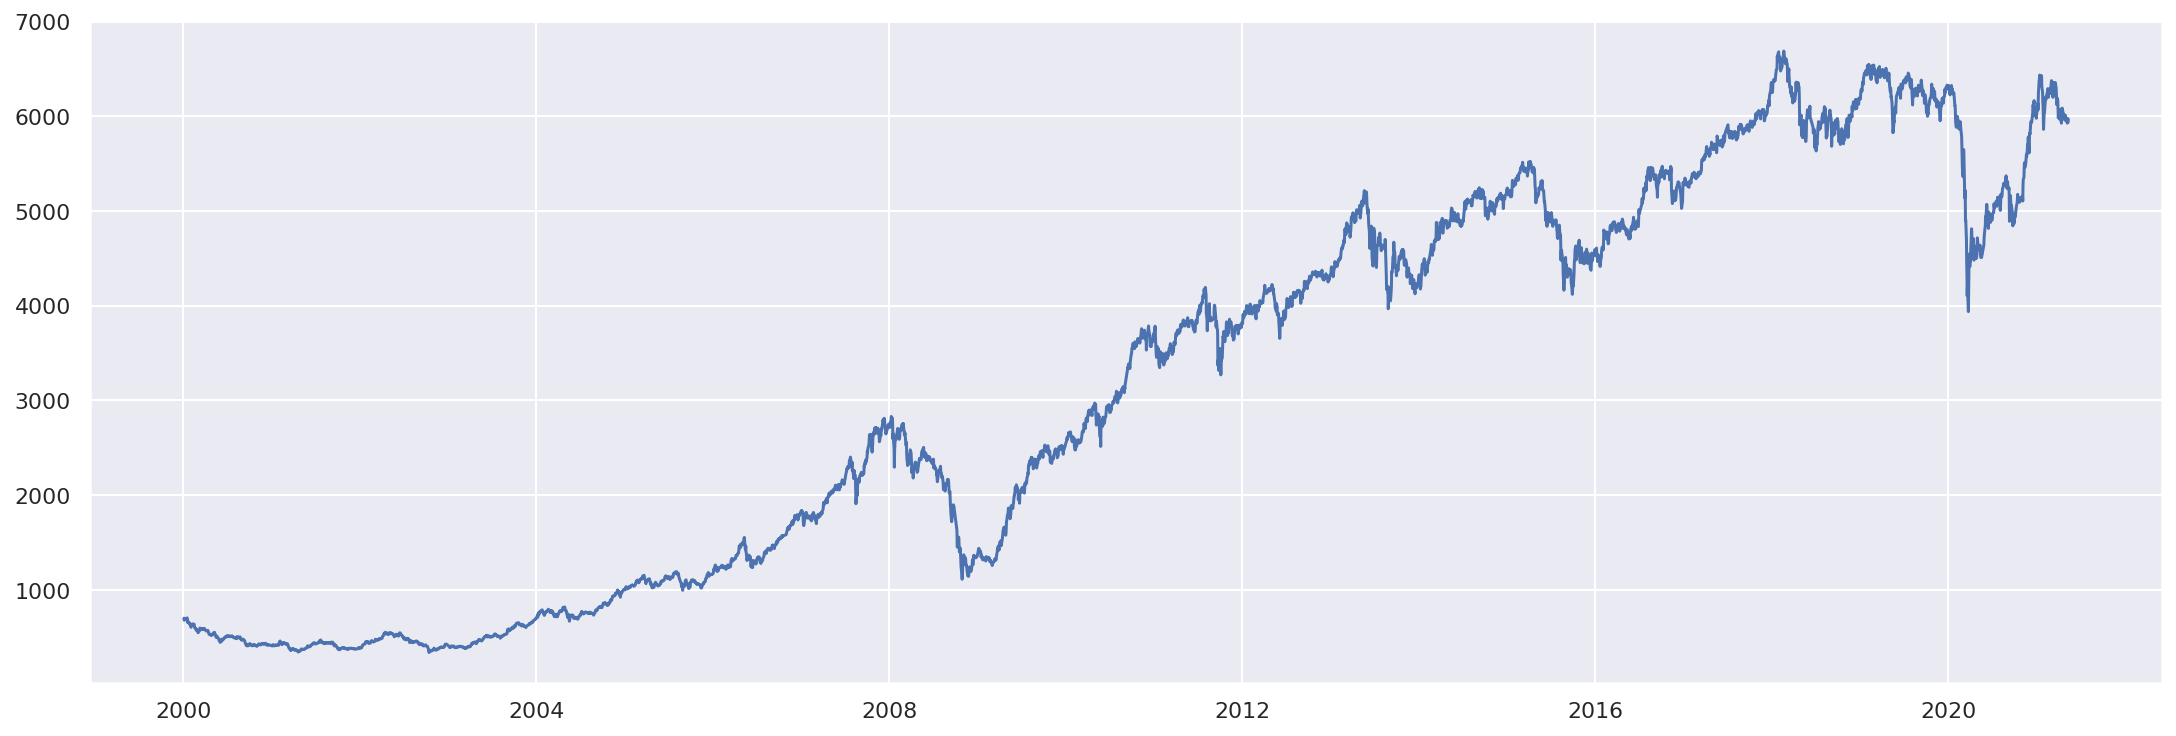

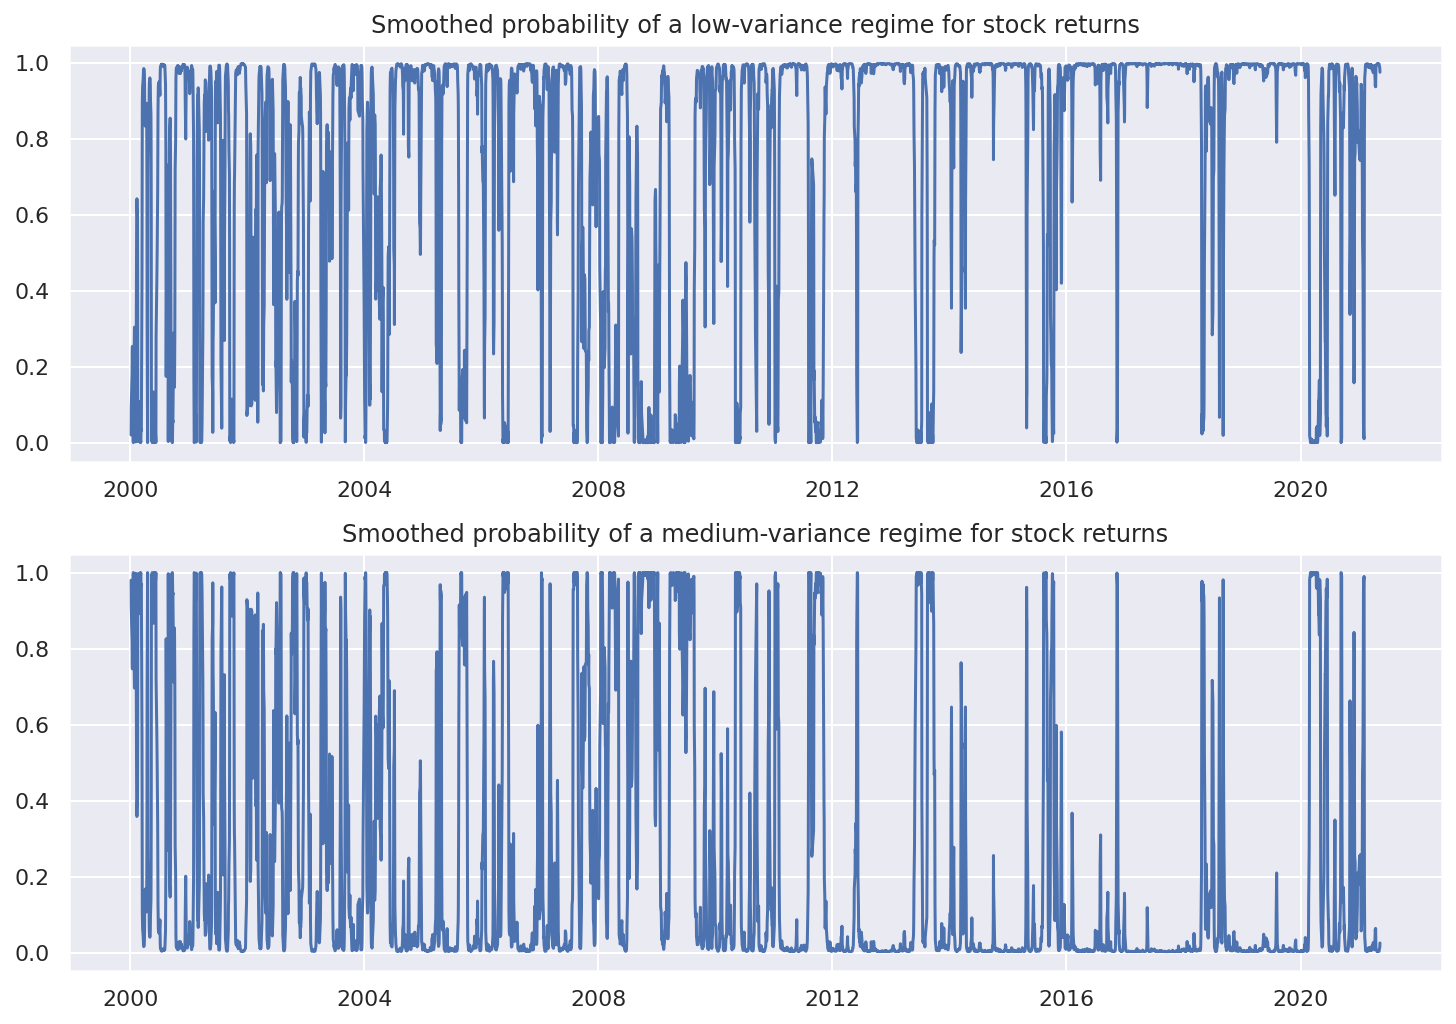

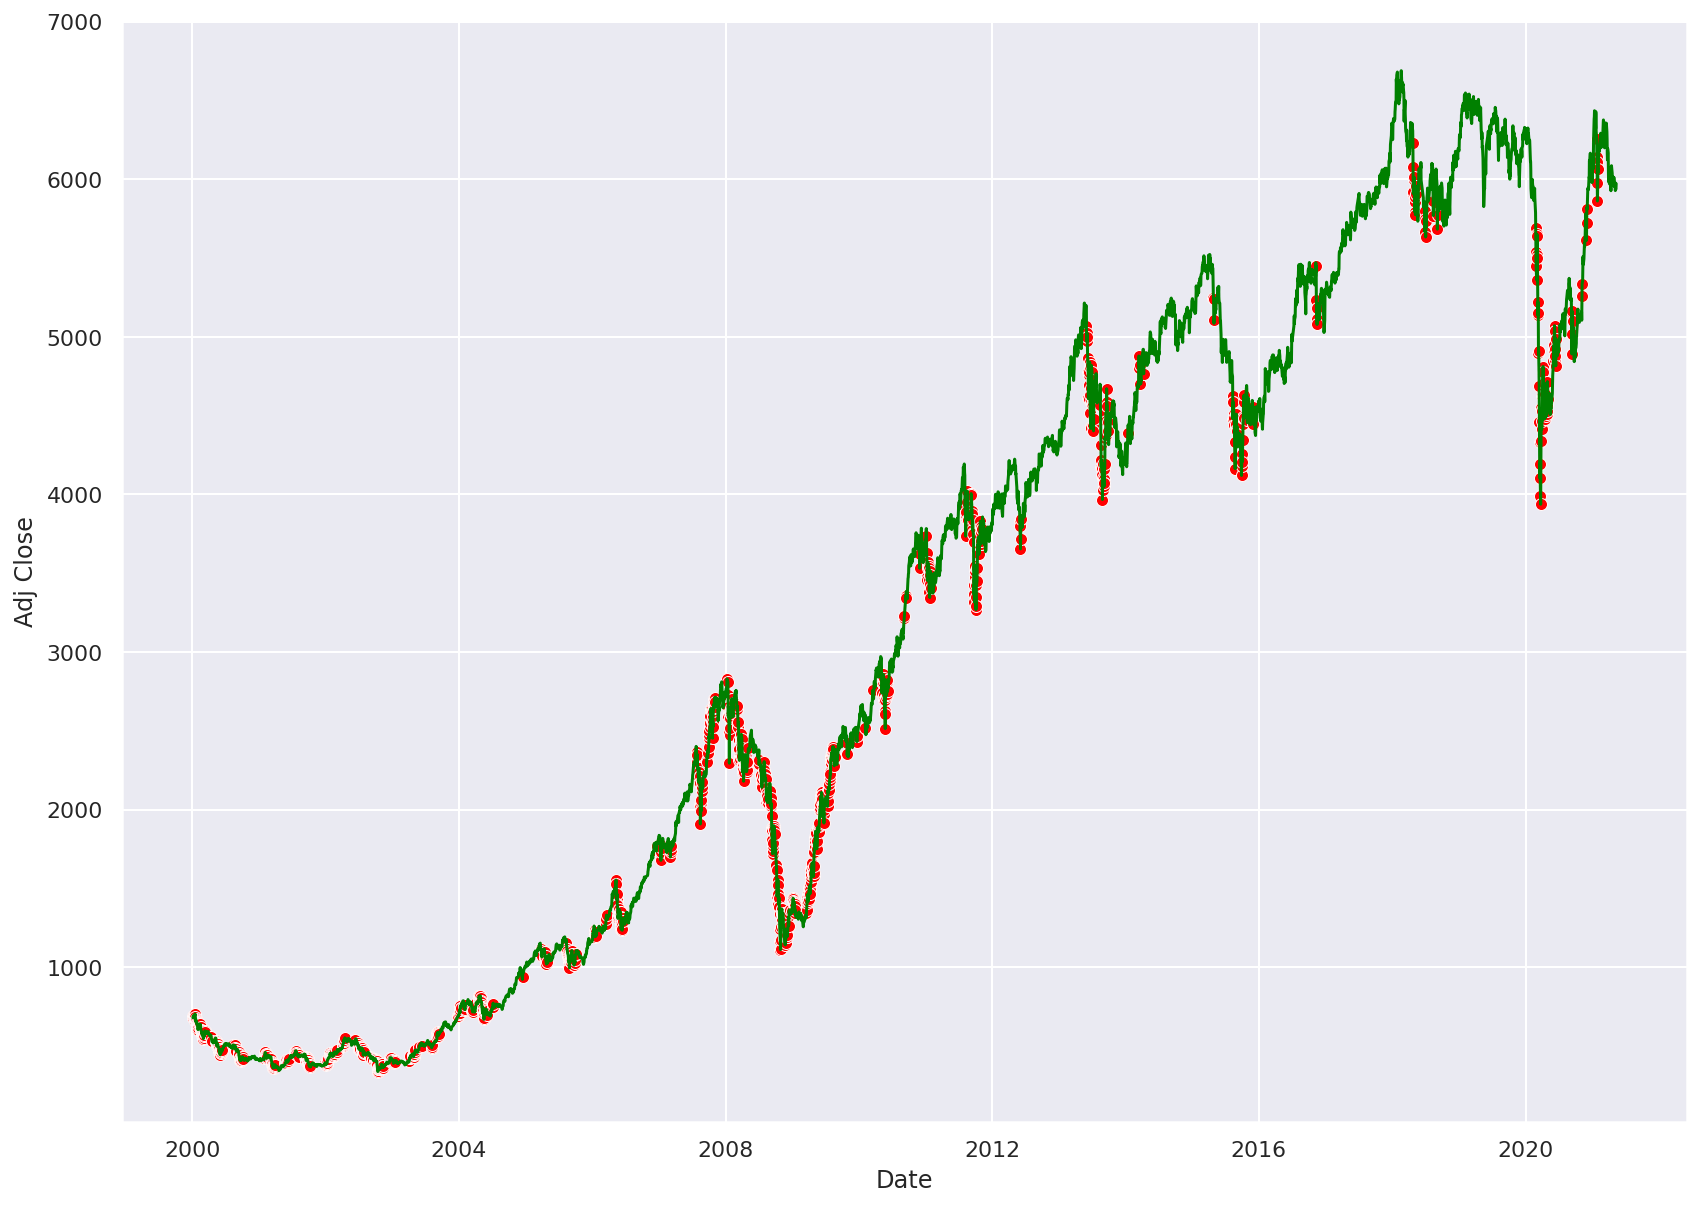

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(bottom=0.2)


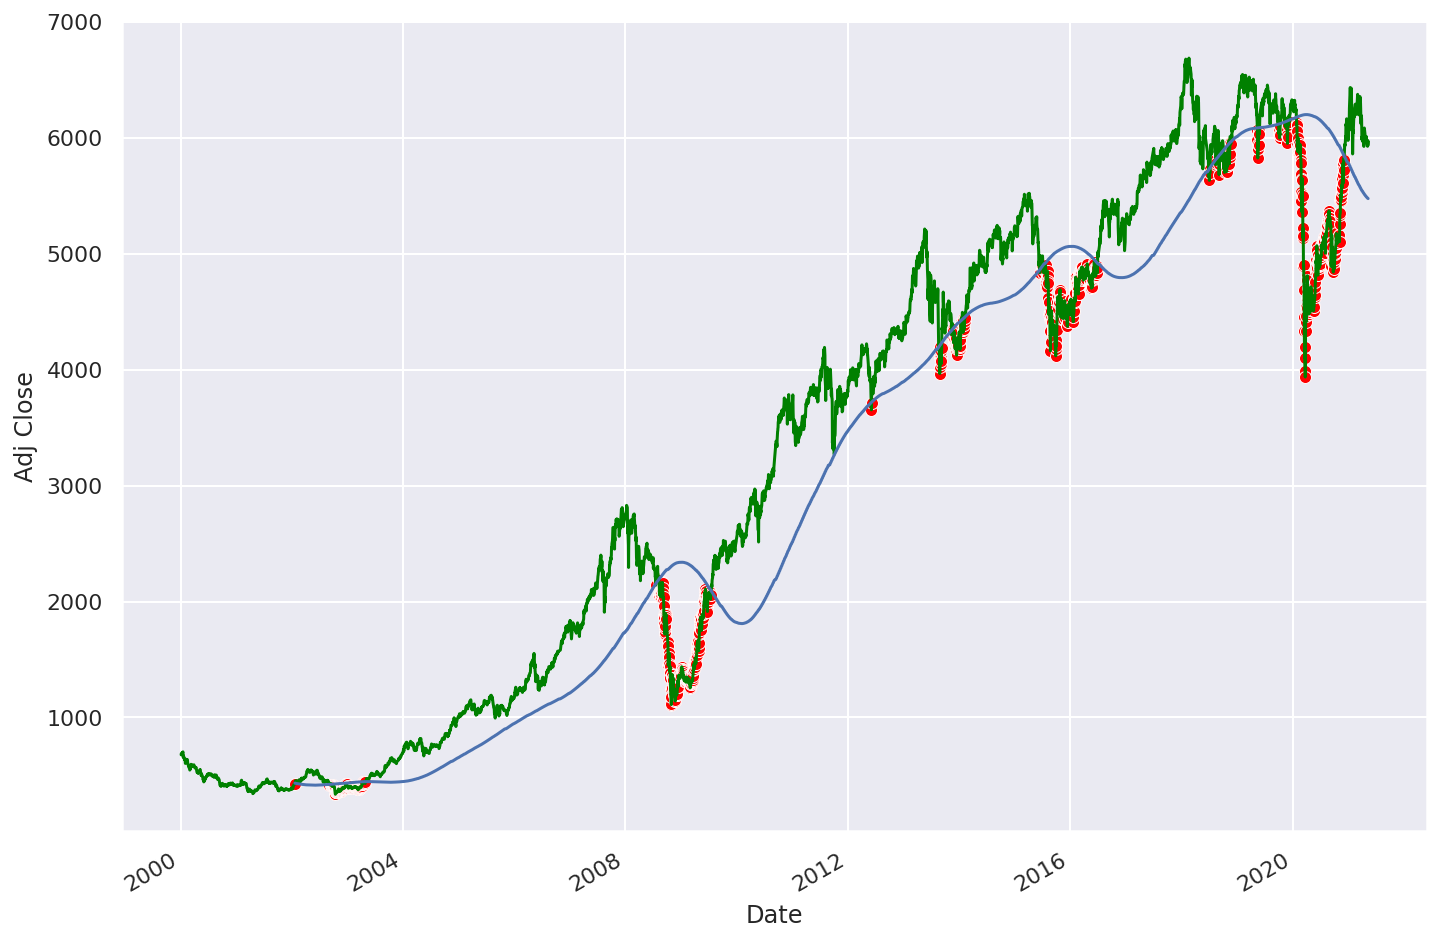

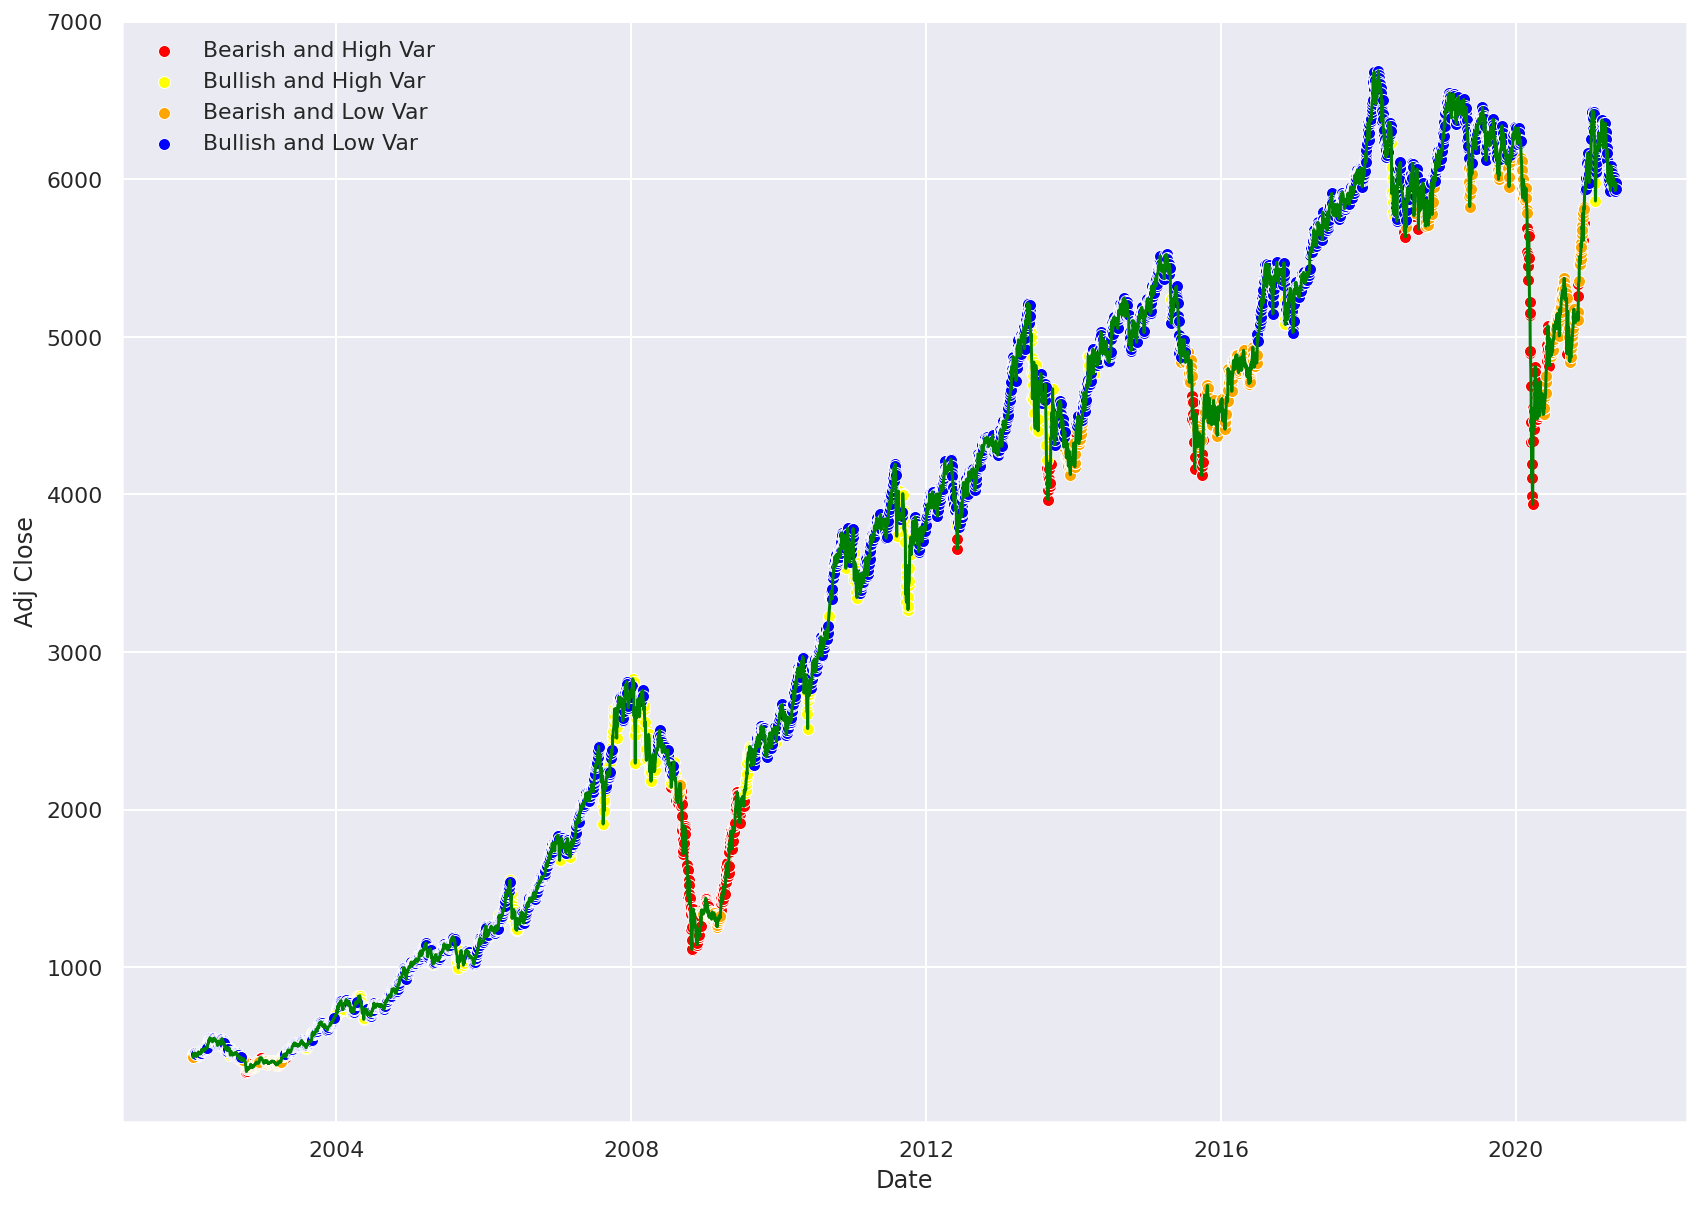

Regime
1   -0.001331
2   -0.001479
3    0.000023
4    0.001236
Name: Adj Close Return, dtype: float64
Regime
1    0.026844
2    0.022818
3    0.009042
4    0.008364
Name: Adj Close Return, dtype: float64
Regime
1     351
2     563
3     614
4    3166
Name: Adj Close Return, dtype: int64


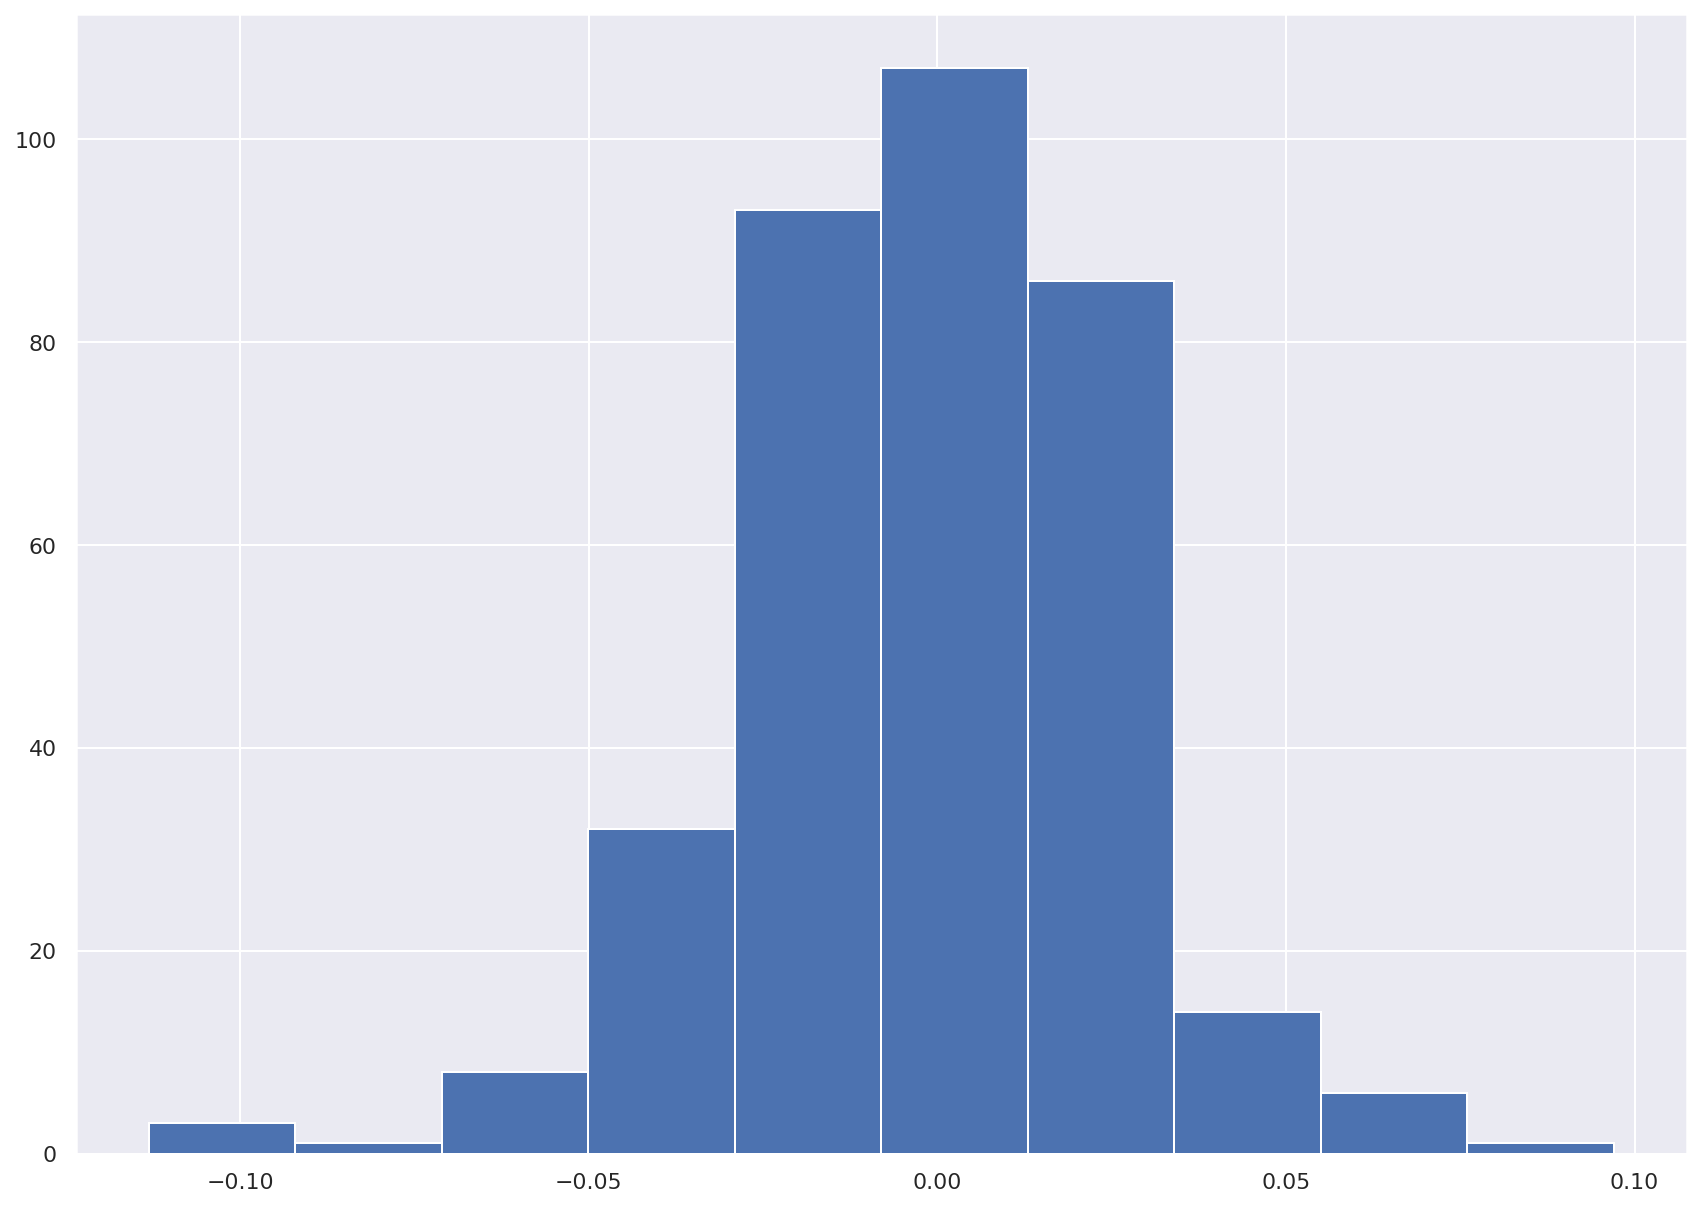

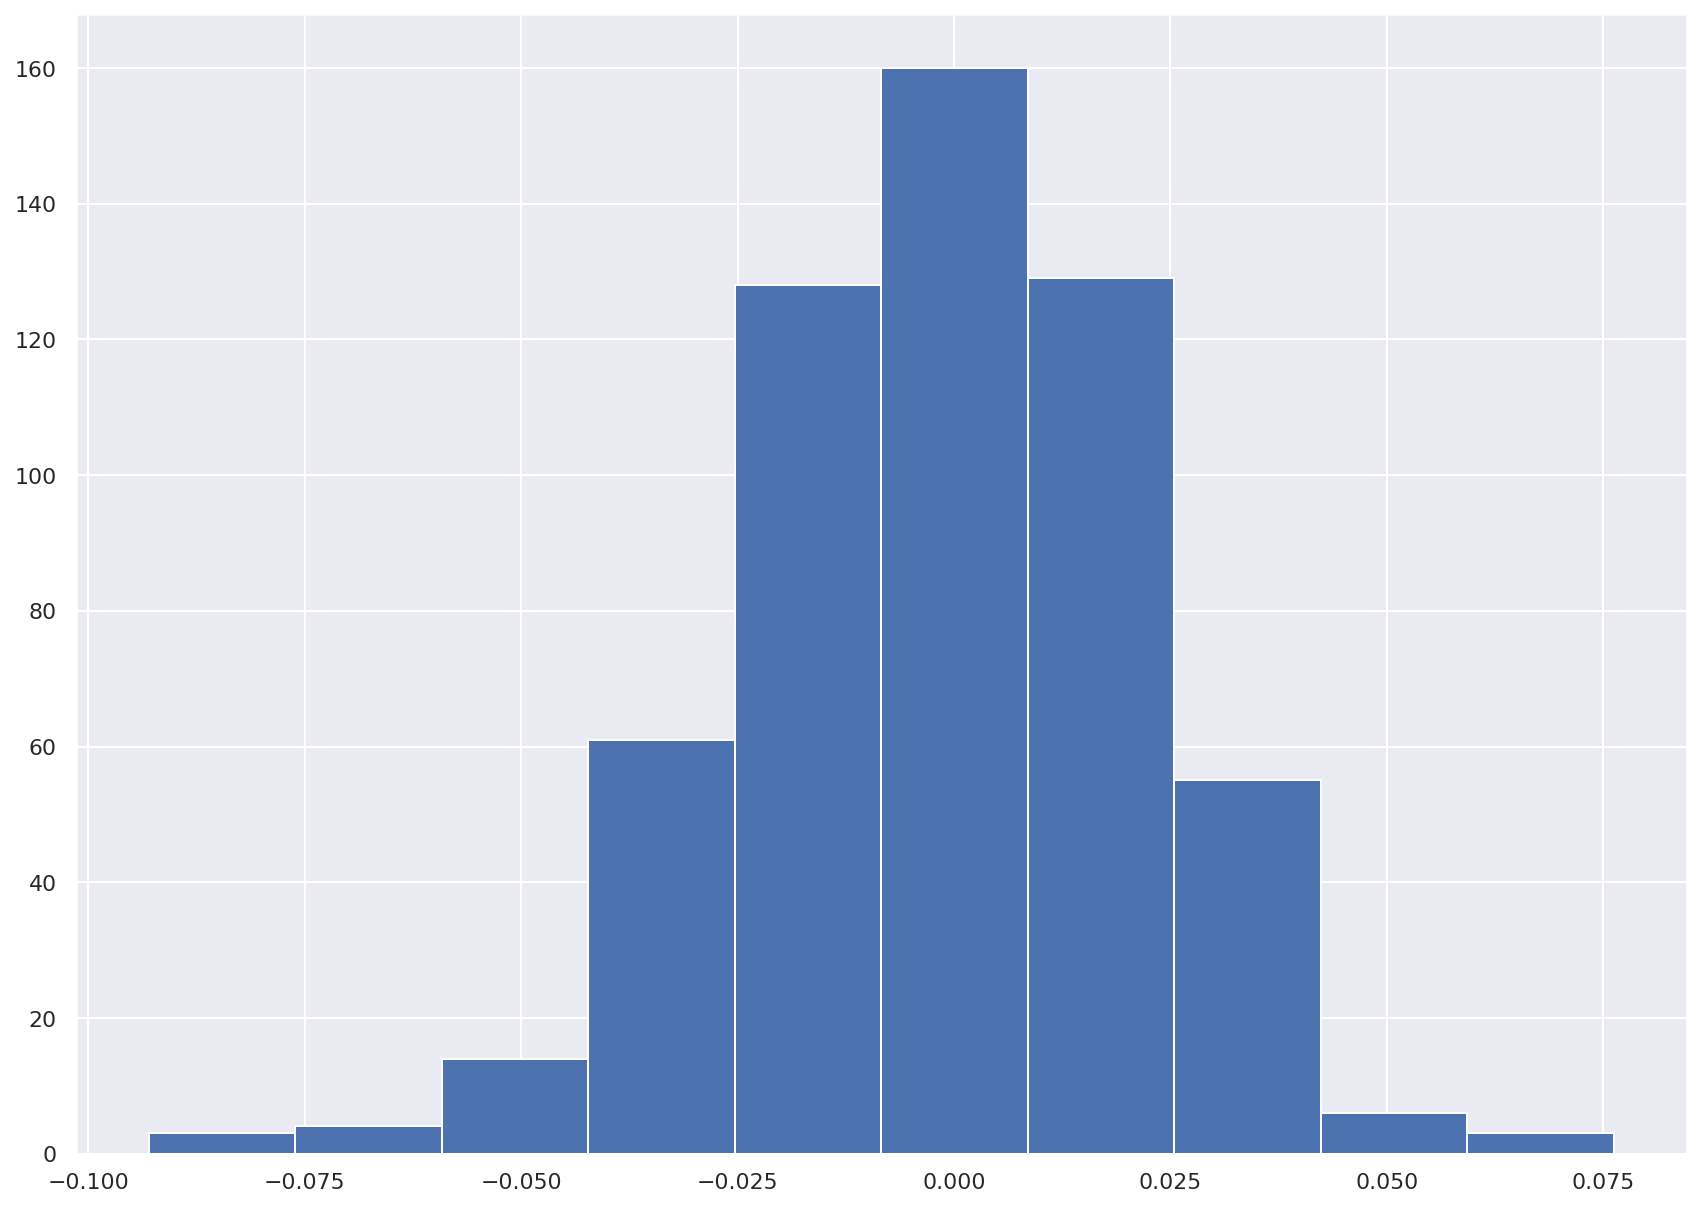

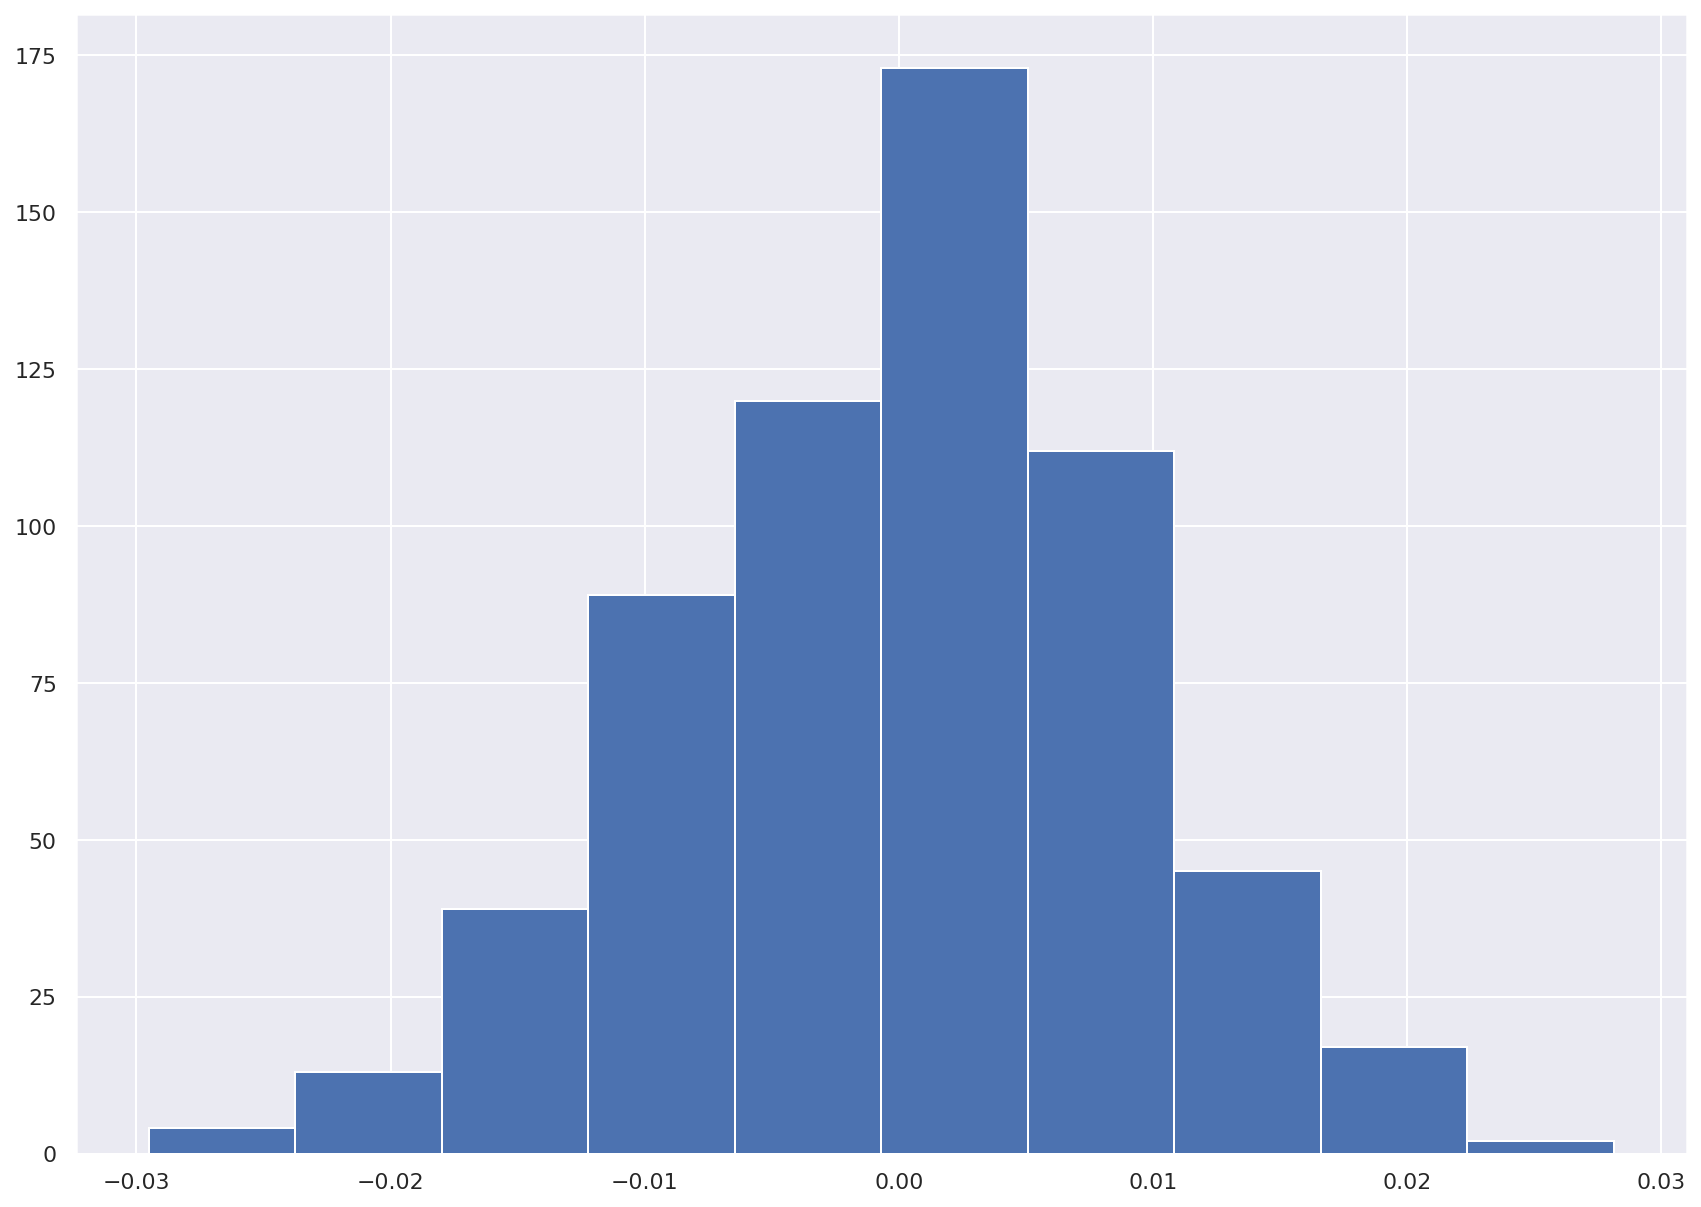

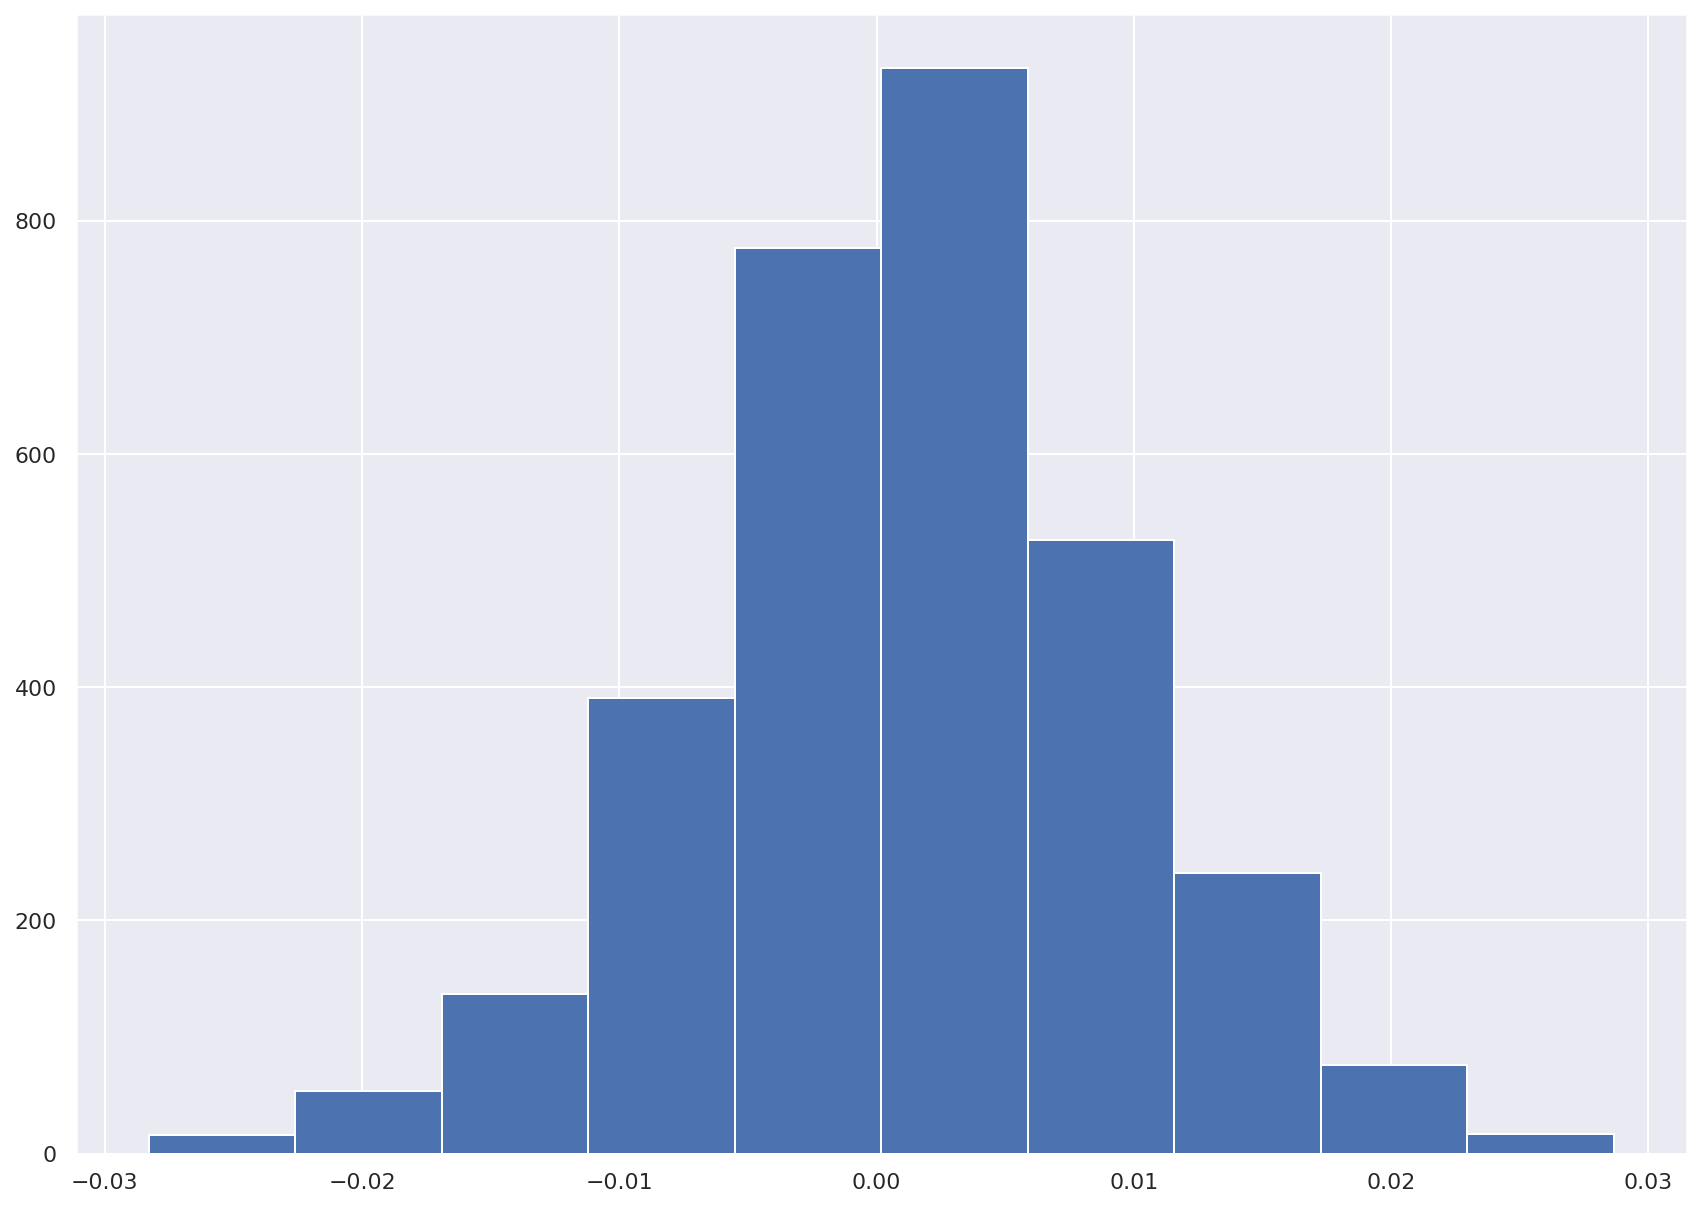

In [ ]:
start_date = '2000-01-01'
# User pandas_reader.data.DataReader to load the desired data. As simple as that.
# S_P = data.DataReader('^GSPC', 'yahoo', start_date)
IHSG = Regime('^JKSE', start_date)


  The Trading Strategy as used by our reference papers are divided by 4 using the wyckoff framework
-    Bullish Low Variance → Advance 
-   Bearish High Variance → Decline   
-    Bullish High Variance → Accumulation 
-    Bearish Low Variance → Distribution 

With Trading SIgnal Analysis using

-    Bollinger Bands - Volatility bands
-    Relative Strength Index - Price change momentum oscilator
-    Fibbonaci Retracements - Fibonacci ratios for extreme point distance measurement
-     Exponential Moving Average - moving average with emphasis on the latest price


However, we will proof the individual analysis that are done in the papers. including how to use the individual trading signal analysis (which depends on crossovers.)



In [ ]:
# """
#   First, Prepare the Technical Charts Analysis
# """

# Close = IHSG

# #Bollinger Bands
# Middle_Bollinger = Close['Adj Close'].rolling(12).mean()
# Up_Bollinger = Close['Adj Close'].rolling(12).mean() + 1.5 * Close['Adj Close'].rolling(12).std()
# Down_Bollinger = Close['Adj Close'].rolling(12).mean() - 1.5 * Close['Adj Close'].rolling(12).std()

# #Fibonnaci Crossover
# Max_Price = Close['Adj Close'].rolling(24).max().to_frame()
# Min_Price = Close['Adj Close'].rolling(24).min().to_frame()
# Diff = Max_Price - Min_Price
# Max_Price['Level 1'] = Max_Price[['Adj Close']] - 0.236 * Diff
# Max_Price['Level 2'] = Max_Price[['Adj Close']] - 0.382 * Diff
# Max_Price['Level 3'] = Max_Price[['Adj Close']] - 0.618 * Diff
# Min_Price['Level 1'] = Min_Price[['Adj Close']] + 0.236 * Diff
# Min_Price['Level 2'] = Min_Price[['Adj Close']] + 0.382 * Diff
# Min_Price['Level 3'] = Min_Price[['Adj Close']] + 0.618 * Diff

# #MACD 
# EMA_26 = Close['Adj Close'].ewm(26).mean()
# EMA_12 = Close['Adj Close'].ewm(12).mean()
# MACD = (EMA_12 - EMA_26).to_frame()

# #RSI Crossover
# Difference = Close['Adj Close'].diff().to_frame()
# Difference['Gain'] = 0
# Difference.loc[Difference['Adj Close'] > 0,'Gain'] = Difference.loc[Difference['Adj Close'] > 0,'Adj Close']
# Difference['Loss'] = 0
# Difference.loc[Difference['Adj Close'] < 0,'Loss'] = -Difference.loc[Difference['Adj Close'] < 0,'Adj Close']
# MAR = Difference['Gain'].rolling(12).mean()/Difference['Loss'].rolling(12).mean()
# RSI = (100 - (100/(MAR+1))).to_frame()

# #Profit and Exit Signals
# EMA = Close['Adj Close'].ewm(12).mean()
# Adj_Factor = Close['Adj Close']/Close['Close']
# ATR = pd.concat([Close['High']*Adj_Factor - Close['Low']*Adj_Factor,
#       np.abs(Close['High']*Adj_Factor - Close['Adj Close'].shift()),
#       np.abs(Close['Low']*Adj_Factor - Close['Adj Close'].shift())],axis=1).max(axis=1).to_frame()

# from functools import reduce
# dfs = [Close[['Adj Close']], Middle_Bollinger, Up_Bollinger, Down_Bollinger, Max_Price, Min_Price, MACD, RSI, EMA, ATR]
# df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
#                                             how='outer'), dfs)

# df_merged.columns = ['Adj Close', 'Bollinger Mid', 'Bollinger Up', 'Bollinger Down', 'Max', 'F_Retrace_Up_1', 'F_Retrace_Up_2', 'F_Retrace_Up_3', 'Min', 'F_Retrace_Down_1', 'F_Retrace_Down_2', 'F_Retrace_Down_3',
#                      'MACD','RSI', 'EMA', 'ATR']
# df_merged

In [ ]:

def TA(Close,Bollinger_Day_Mid = 12,Bollinger_Day_Up = 12,Bollinger_Day_Down = 12, Bollinger_Dev_Up = 1.5, Bollinger_Dev_Down = 1.5, Fibonacci_Day = 24, MACD_Long_Day = 26, MACD_Short_Day = 12, RSI_Day = 12, ATR_Day = 12):
  from functools import reduce
  #Bollinger Bands
  Middle_Bollinger = Close['Adj Close'].rolling(Bollinger_Day_Mid).mean()
  Up_Bollinger = Close['Adj Close'].rolling(Bollinger_Day_Up).mean() + Bollinger_Dev_Up * Close['Adj Close'].rolling(Bollinger_Day_Up).std()
  Down_Bollinger = Close['Adj Close'].rolling(Bollinger_Day_Down).mean() - Bollinger_Dev_Down * Close['Adj Close'].rolling(Bollinger_Day_Down).std()

  #Fibonnaci Crossover
  Max_Price = Close['Adj Close'].rolling(Fibonacci_Day).max().to_frame()
  Min_Price = Close['Adj Close'].rolling(Fibonacci_Day).min().to_frame()
  Diff = Max_Price - Min_Price
  Max_Price['Level 1'] = Max_Price[['Adj Close']] - 0.236 * Diff
  Max_Price['Level 2'] = Max_Price[['Adj Close']] - 0.382 * Diff
  Max_Price['Level 3'] = Max_Price[['Adj Close']] - 0.618 * Diff
  Min_Price['Level 1'] = Min_Price[['Adj Close']] + 0.236 * Diff
  Min_Price['Level 2'] = Min_Price[['Adj Close']] + 0.382 * Diff
  Min_Price['Level 3'] = Min_Price[['Adj Close']] + 0.618 * Diff

  #MACD 
  EMA_Long = Close['Adj Close'].ewm(MACD_Long_Day).mean()
  EMA_Short = Close['Adj Close'].ewm(MACD_Short_Day).mean()
  MACD = (EMA_Short - EMA_Long).to_frame()

  #RSI Crossover
  Difference = Close['Adj Close'].diff().to_frame()
  Difference['Gain'] = 0
  Difference.loc[Difference['Adj Close'] > 0,'Gain'] = Difference.loc[Difference['Adj Close'] > 0,'Adj Close']
  Difference['Loss'] = 0
  Difference.loc[Difference['Adj Close'] < 0,'Loss'] = -Difference.loc[Difference['Adj Close'] < 0,'Adj Close']
  MAR = Difference['Gain'].ewm(span = RSI_Day).mean()/Difference['Loss'].ewm(span = RSI_Day).mean()
  RSI = (100 - (100/(MAR+1))).to_frame()
    
  #Profit and Exit Signals
  EMA = Close['Adj Close'].ewm(ATR_Day).mean()
  Adj_Factor = Close['Adj Close']/Close['Close']
  ATR = pd.concat([Close['High']*Adj_Factor - Close['Low']*Adj_Factor,
        np.abs(Close['High']*Adj_Factor - Close['Adj Close'].shift()),
        np.abs(Close['Low']*Adj_Factor - Close['Adj Close'].shift())],axis=1).max(axis=1).to_frame()

  dfs = [Close[['Adj Close']], Middle_Bollinger, Up_Bollinger, Down_Bollinger, Max_Price, Min_Price, MACD, RSI, EMA, ATR]
  df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                              how='outer'), dfs)

  df_merged.columns = ['Adj Close', 'Bollinger Mid', 'Bollinger Up', 'Bollinger Down', 'Max', 'F_Retrace_Up_1', 'F_Retrace_Up_2', 'F_Retrace_Up_3', 'Min', 'F_Retrace_Down_1', 'F_Retrace_Down_2', 'F_Retrace_Down_3',
                      'MACD','RSI', 'EMA', 'ATR']
  df_merged

  return df_merged



  Now that we have the trading indicators
  Let's Define the Buy and Sell Strategy
  Strategy divided into four:

- Advance       (bullish low Volatility)
  
- Accumulation  (Bullish High Volatility)
  
- Decline       (Bearish High Volatility)
  
- Distribution  (Bearish Low Volatility)

In [ ]:
# """
#   We Start with the Advance Strategy
#   This Strategy maximises Trend and Pullback.
#   Bear in Mind we are only going long

#   With Long Signals from the reference
  
#   Long Signals 
  
#    Price crosses below lower Bollinger band (1.5 SD) 
#    Relative Strength Index crosses below lower threshold (40) 
#    Price crosses below 38.2% Fibonacci level 
  
#   Exit Long Signals 
  
#    Price crosses above upper Bollinger band (1.5 SD) 
#    Relative Strength Index crosses below lower threshold (70) 
#    Price crosses below short-term Exponential Moving Average (10 days) 
#    Price crosses below 61.8% Fibonacci level 
#    Take profit at EMA + 3*ATR 
#    Take loss at EMA – 3*ATR 

# # """
# pd.set_option('max_rows', 99999)
# # pd.set_option('max_colwidth', 400)
# # pd.describe_option('max_colwidth')
# #Enter and Exit Flagging With Backtest Functions defined.

# def Backtest(df):

#   for i in range(1, df.shape[0]):
#     # print(i)
#     if (df.iloc[i-1, 3] == 0) & (df.iloc[i-1, 1] == 1):
#       df.iloc[i, 3] = 1
#     elif (df.iloc[i-1, 3] == 1) & (df.iloc[i-1, 2] == 1):
#       df.iloc[i, 3] = 0
#     else :
#       df.iloc[i, 3] = df.iloc[i-1, 3]
      

#     if (df.iloc[i, 3] == 1) & (df.iloc[i-1, 3] == 0) :
#       df.iloc[i, 4] = df.iloc[i-1, 4] * (1 - .0015) 
#     elif (df.iloc[i, 3] == 1) & (df.iloc[i, 2] == 1) :
#       df.iloc[i, 4] = df.iloc[i-1, 4] * (df.iloc[i, 0]/df.iloc[i-1, 0] - .0025)
#     elif (df.iloc[i, 3] == 1) :
#       df.iloc[i, 4] = df.iloc[i-1, 4] * (df.iloc[i, 0]/df.iloc[i-1, 0]) 
#     else :
#       df.iloc[i, 4] = df.iloc[i-1, 4]

#   return df


# Close = IHSG

# Advance_Signals = TA(Close[['Adj Close','High','Low','Open','Close']])



# # #Bollinger Bands Strategy
# # Portfolio_Performance = Close[['Adj Close']]
# # Portfolio_Performance['Entry'] = ((Advance_Signals['Adj Close']<Advance_Signals['Bollinger Down']) & (Advance_Signals['Adj Close'].shift()>Advance_Signals['Bollinger Down'])).astype(int)
# # Portfolio_Performance['Exit'] = ((Advance_Signals['Adj Close']>Advance_Signals['Bollinger Up']) & (Advance_Signals['Adj Close'].shift()<Advance_Signals['Bollinger Up'])).astype(int)
# # Portfolio_Performance['Position'] = 0
# # Portfolio_Performance['Portfolio_Value'] = 1
# # Portfolio_Performance = Backtest(Portfolio_Performance)
# # Portfolio_Performance['Portfolio_Value'].plot(label='Bollinger')

# # #RSI Strategy
# # Portfolio_Performance = Close[['Adj Close']]
# # Portfolio_Performance['Entry'] = (Advance_Signals['RSI']<40).astype(int)
# # Portfolio_Performance['Exit'] = (Advance_Signals['RSI']>70).astype(int)
# # Portfolio_Performance['Position'] = 0
# # Portfolio_Performance['Portfolio_Value'] = 1
# # Portfolio_Performance = Backtest(Portfolio_Performance)
# # Portfolio_Performance['Portfolio_Value'].plot(label = 'RSI')


# #Combined Strategy
# Portfolio_Performance = Close[['Adj Close','High','Low','Open','Close','Regime']]

# Portfolio_Performance['Entry_Bollinger'] = ((Advance_Signals['Adj Close']<Advance_Signals['Bollinger Down']) & (Advance_Signals['Adj Close'].shift()>Advance_Signals['Bollinger Down']))
# Portfolio_Performance['Entry_RSI'] = (Advance_Signals['RSI']<40)
# Portfolio_Performance['Entry_Fibonacci'] = (Advance_Signals['F_Retrace_Up_2']<Advance_Signals['Adj Close'])
# # Portfolio_Performance['Entry_Regime'] = (Portfolio_Performance['Regime'] == 4) | (Portfolio_Performance['Regime'] == 1)

# Portfolio_Performance['Entry'] = (Portfolio_Performance['Entry_Bollinger']) | (Portfolio_Performance['Entry_RSI']) | (Portfolio_Performance['Entry_Fibonacci'])

# Portfolio_Performance['Exit_Bollinger'] = ((Advance_Signals['Adj Close']>Advance_Signals['Bollinger Up']) & (Advance_Signals['Adj Close'].shift()<Advance_Signals['Bollinger Up']))
# Portfolio_Performance['Exit_RSI'] = (Advance_Signals['RSI']>70)
# Portfolio_Performance['Exit_Fibonacci'] = (Advance_Signals['F_Retrace_Up_3']<Advance_Signals['Adj Close']).astype(int)
# Portfolio_Performance['Exit_ATR_Profit'] = (Advance_Signals['Adj Close'] > (Advance_Signals['EMA'] + 3 * Advance_Signals['ATR']))
# Portfolio_Performance['Exit_ATR_Loss'] = (Advance_Signals['Adj Close'] > (Advance_Signals['EMA'] - 3 * Advance_Signals['ATR']))
# Portfolio_Performance['Exit_Regime'] = (Portfolio_Performance['Regime'] == 1)

# Portfolio_Performance['Exit'] = (Portfolio_Performance['Exit_Regime']) | (Portfolio_Performance['Exit_Bollinger']) & (Portfolio_Performance['Exit_RSI']) & (Portfolio_Performance['Exit_Fibonacci']) & (Portfolio_Performance['Exit_ATR_Profit'] | Portfolio_Performance['Exit_ATR_Loss'])

# Portfolio_Performance = Portfolio_Performance[['Adj Close', 'Entry', 'Exit']]

# Portfolio_Performance['Position'] = 0
# Portfolio_Performance['Portfolio_Value'] = 1
# # Portfolio_Performance = Backtest(Portfolio_Performance)

# #change exit before first entry to 0
# Portfolio_Performance['Exit'][:np.nonzero(Portfolio_Performance['Entry'].values)[0][0]] = False

# Vectorized_Backtest(Portfolio_Performance)

# # np.diff(np.concatenate(([-1],) + np.nonzero(np.diff(Max_Value) != 0) + ([len(Max_Value)-1],)))
# # Portfolio_Performance['Portfolio_Value'].plot(label = 'Combined')

# # plt.legend()



In [ ]:
  # Buy Boolean
  Buy = [True,True,True,True,True,True]
  [Bollinger_Buy_Up,Bollinger_Buy_Down,RSI_Buy_Over,RSI_Buy_Under,Fibonacci_Buy,MACD_Buy] = Buy
  # Sell Boolean
  Sell = [True,True,True,True,True,True]
  [Bollinger_Sell_Up,Bollinger_Sell_Down,RSI_Sell_Over,RSI_Sell_Under,Fibonacci_Sell,MACD_Sell] = Sell
  # ATR Boolean
  ATR = [True,True]
  [ATR_Entry,ATR_Exit] = ATR


True

In [ ]:
 """
  We Start with the Advance Strategy
  This Strategy maximises Trend and Pullback.
  Bear in Mind we are only going long

  With Long Signals from the reference
  
  Long Signals 
  
   Price crosses below lower Bollinger band (1.5 SD) 
   Relative Strength Index crosses below lower threshold (40) 
   Price crosses below 38.2% Fibonacci level 
  
  Exit Long Signals 
  
   Price crosses above upper Bollinger band (1.5 SD) 
   Relative Strength Index crosses below lower threshold (70) 
   Price crosses below short-term Exponential Moving Average (10 days) 
   Price crosses below 61.8% Fibonacci level 
   Take profit at EMA + 3*ATR 
   Take loss at EMA – 3*ATR 

  """

def Trade_Simulation(Close,Buy = [True,True,True,True,True,True],Sell = [True,True,True,True,True,True],ATR = [True,True],Regime_Entry=[1,2,3,4],Regime_Exit=[],
                     Bollinger_Day_Down = 12,Bollinger_Day_Up=12, Bollinger_Dev_Up = 1.5, Bollinger_Dev_Down = 1.5, Fibonacci_Day = 24, MACD_Long_Day = 26, MACD_Short_Day = 12, RSI_Day = 12, ATR_Day = 12,
                     RSI_Entry = 30, RSI_Exit = 70, ATR_Profit = 3, ATR_Loss = 3):
  """
  Backtest function that runs Technical Analysis,
  Get Entry and Exit Signals depening on the input
  And Try to Backtest using the Entry and Exit signals with Transactions fee of 0.15% and 0.25%
  Try using Backtest for loop based backtest, however the function assumes sell priority
  Using Vectorized backtest provide much faster running time. the code only execute buy only or sell only, no priority in selling.

  """

  def Backtest(df):

    for i in range(1, df.shape[0]):
      
      # Entry Signals and no Position 
      if (df.iloc[i-1, 3] == 0) & (df.iloc[i-1, 1] == 1):
        df.iloc[i, 3] = 1
      # Exit Signals and Position  
      elif (df.iloc[i-1, 3] == 1) & (df.iloc[i-1, 2] == 1):
        df.iloc[i, 3] = 0
      # Else lookback  
      else :
        df.iloc[i, 3] = df.iloc[i-1, 3]
        
      #Entry Position Pay Fees
      if (df.iloc[i, 3] == 1) & (df.iloc[i-1, 3] == 0) :
        df.iloc[i, 4] = df.iloc[i-1, 4] * (1 - .0015)
        df.iloc[i, 5] = df.iloc[i-1, 4]
      #Exit Position Pay Fees  
      elif (df.iloc[i, 3] == 1) & (df.iloc[i, 2] == 1) :
        df.iloc[i, 4] = df.iloc[i-1, 4] * (df.iloc[i, 0]/df.iloc[i-1, 0] - .0025)
        # df.iloc[i, 5] = df.iloc[i, 4]
      #Hold Position
      elif (df.iloc[i, 3] == 1) :
        df.iloc[i, 4] = df.iloc[i-1, 4] * (df.iloc[i, 0]/df.iloc[i-1, 0])
        df.iloc[i, 5] = df.iloc[i-1, 5] 
      #Rest Trade Position
      else :
        df.iloc[i, 4] = df.iloc[i-1, 4]
        df.iloc[i, 5] = df.iloc[i-1, 5] 

    return df

  def Vectorized_Backtest(df):
    returns = df['Adj Close'].pct_change().values

    a = (df['Entry'].astype(int) - df['Exit'].astype(int))

    index = np.nonzero(a.values)[0]
    index = index[index != (len(a)-1)]

    nonzero_Index = np.nonzero(a[index].diff().values)[0]
    
    values = np.array([-1] * len(index[nonzero_Index]))
    values[::2] = 1
    
    a[:] = 0
    a[index[nonzero_Index] + 1] = values
    Position = a.cumsum()

    returns[(Position.shift()==0) & (Position==0) ] = 0
    returns[0] = 0
    returns[index[nonzero_Index][values==1] + 1] =  (1 - 0.0015 ) * (1 + returns[index[nonzero_Index][values==1] + 1]) - 1
    returns[index[nonzero_Index][values==-1] + 1] = (1 + returns[index[nonzero_Index][values==-1] + 1]) * (1-0.0025) - 1


    Portfolio_Value = (returns + 1).cumprod()

    df['Position'] = Position
    df['Portfolio_Value'] = Portfolio_Value

    return df
  
  Advance_Signals = TA(Close[['Adj Close','High','Low','Open','Close']],12,Bollinger_Day_Down,Bollinger_Day_Up, Bollinger_Dev_Up, Bollinger_Dev_Down, Fibonacci_Day, MACD_Long_Day, MACD_Short_Day, RSI_Day, ATR_Day)

  Portfolio_Performance = Close[['Adj Close','High','Low','Open','Close','Regime']]

  # Buy Boolean
  [Bollinger_Buy_Up,Bollinger_Buy_Down,RSI_Buy_Over,RSI_Buy_Under,Fibonacci_Buy,MACD_Buy] = Buy
  # Sell Boolean
  [Bollinger_Sell_Up,Bollinger_Sell_Down,RSI_Sell_Over,RSI_Sell_Under,Fibonacci_Sell,MACD_Sell] = Sell
  # ATR Boolean
  [ATR_Entry,ATR_Exit] = ATR

  Portfolio_Performance['Entry_Bollinger_Up'] = (Advance_Signals['Adj Close']>Advance_Signals['Bollinger Up']) & (Advance_Signals['Adj Close'].shift()<Advance_Signals['Bollinger Up']) & (Bollinger_Buy_Up) 
  Portfolio_Performance['Entry_Bollinger_Down'] = ((Advance_Signals['Adj Close']<Advance_Signals['Bollinger Down']) & (Advance_Signals['Adj Close'].shift()>Advance_Signals['Bollinger Down'])) & (Bollinger_Buy_Down) 
  Portfolio_Performance['Entry_RSI_Over'] = (Advance_Signals['RSI']>RSI_Entry) & (RSI_Buy_Over)
  Portfolio_Performance['Entry_RSI_Under'] = (Advance_Signals['RSI']<RSI_Entry) & (RSI_Buy_Under)
  Portfolio_Performance['Entry_Fibonacci'] = (Advance_Signals['F_Retrace_Up_2']<Advance_Signals['Adj Close']) & (Fibonacci_Buy)
  Portfolio_Performance['Entry_MACD'] = (Advance_Signals['MACD'] > 0) & (Advance_Signals['MACD'].shift() < 0) & (MACD_Buy)
  Portfolio_Performance['Entry_Regime'] = Portfolio_Performance['Regime'].isin(Regime_Entry)

  Portfolio_Performance['Entry'] = ( (Portfolio_Performance['Entry_Regime']) & ( ((Portfolio_Performance['Entry_Bollinger_Up']) | (Portfolio_Performance['Entry_Bollinger_Down'])) | ((Portfolio_Performance['Entry_RSI_Over']) | (Portfolio_Performance['Entry_RSI_Under'])) | (Portfolio_Performance['Entry_Fibonacci']) ) ).astype(int)

  Portfolio_Performance['Exit_Bollinger_Up'] = (Advance_Signals['Adj Close']>Advance_Signals['Bollinger Up']) & (Advance_Signals['Adj Close'].shift()<Advance_Signals['Bollinger Up']) | ( not Bollinger_Sell_Up)
  Portfolio_Performance['Exit_Bollinger_Down'] = ((Advance_Signals['Adj Close']<Advance_Signals['Bollinger Down']) & (Advance_Signals['Adj Close'].shift()>Advance_Signals['Bollinger Down'])) | ( not Bollinger_Sell_Down)
  Portfolio_Performance['Exit_RSI_Over'] = (Advance_Signals['RSI']>RSI_Exit) | ( not RSI_Sell_Over)
  Portfolio_Performance['Exit_RSI_Under'] = (Advance_Signals['RSI']<RSI_Exit) | ( not RSI_Sell_Under)  
  Portfolio_Performance['Exit_Fibonacci'] = (Advance_Signals['F_Retrace_Up_3']<Advance_Signals['Adj Close']) | ( not Fibonacci_Sell)
  Portfolio_Performance['Exit_MACD'] = (Advance_Signals['MACD'] < 0) & (Advance_Signals['MACD'].shift() > 0) | ( not MACD_Sell)
  Portfolio_Performance['Exit_ATR_Profit'] = (Advance_Signals['Adj Close'] > (Advance_Signals['EMA'] + ATR_Profit * Advance_Signals['ATR'])) | ( not ATR_Entry)
  Portfolio_Performance['Exit_ATR_Loss'] = (Advance_Signals['Adj Close'] > (Advance_Signals['EMA'] - ATR_Loss * Advance_Signals['ATR'])) | ( not ATR_Exit)
  Portfolio_Performance['Exit_Regime'] = (Portfolio_Performance['Regime'].isin(Regime_Exit))

  Portfolio_Performance['Exit'] = ( (Portfolio_Performance['Exit_Regime']) | ((Portfolio_Performance['Exit_Bollinger_Up']) & (Portfolio_Performance['Exit_Bollinger_Down'])) & ((Portfolio_Performance['Exit_RSI_Over']) & (Portfolio_Performance['Exit_RSI_Under'])) & (Portfolio_Performance['Exit_Fibonacci']) & (Portfolio_Performance['Exit_ATR_Profit'] | Portfolio_Performance['Exit_ATR_Loss']) ).astype(int)
  Portfolio_Performance = Portfolio_Performance[['Adj Close', 'Entry', 'Exit']]
  Portfolio_Performance['Position'] = 0
  Portfolio_Performance['Portfolio_Value'] = 1
  Portfolio_Performance['Buy_Value'] = 1

  # Portfolio_Performance = Backtest(Portfolio_Performance)
  Portfolio_Performance = Vectorized_Backtest(Portfolio_Performance)

  return Portfolio_Performance

In [ ]:
# element = [x for x in itertools.product(*[Bollinger_Day,Bollinger_Dev_Up,Bollinger_Dev_Down])]
# print(element)
# import warnings
# warnings.filterwarnings('ignore')
# # Bollinger Fitting Maximising Sharpe
# from functools import reduce
# dfs = [stat_Summary(Trade_Simulation(IHSG,True,False,False,False,True,False,False,False,False,Bollinger_Day=x[0],Bollinger_Dev_Up=x[1],Bollinger_Dev_Down=x[2])) for x in element]
# df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
#                                               how='outer'), dfs)
# # bollinger number 6 is the results [24 days and 1 std]

In [ ]:
  """
  It is also important to create a summary statistics of our performance.
  Here on, We will build
  Total Profit
  CAGR
  Risk
  Information Ratio
  Sharpe 
  Win / Hit Ratio
  Num Trades
  Max Consecutive Losers
  Max Drawdown
  Lake Ratio
  Gain to Pain Ratio
  """

# Portfolio_Performance = Trade_Simulation(IHSG,True,True,True,True,True,True,True,Regime_Entry=[2,3,4],Regime_Exit=[1])
# Portfolio_Performance

def stat_Summary(Portfolio_Performance,Title='Statistics'):
    #Total Profit
    Total_Profit = Portfolio_Performance['Portfolio_Value'][-1] - 1

    #CAGR
    CAGR = np.exp(np.log(Portfolio_Performance['Portfolio_Value']/Portfolio_Performance['Portfolio_Value'].shift()).mean() * 252) - 1

    #Annualized Risk
    Risk =  np.log(Portfolio_Performance['Portfolio_Value']/Portfolio_Performance['Portfolio_Value'].shift()).std() * (252**0.5)

    # Information Ratio
    Portfolio_Performance['Index_Value'] = (Portfolio_Performance['Adj Close'].pct_change()+1).cumprod()
    Portfolio_Returns = np.log(Portfolio_Performance['Portfolio_Value']/Portfolio_Performance['Portfolio_Value'].shift())
    Index_Returns = np.log(Portfolio_Performance['Adj Close']/Portfolio_Performance['Adj Close'].shift())
    Tracking_Error = (Portfolio_Returns - Index_Returns).std() * (252**0.5)
    Return_Performance = (np.exp((Portfolio_Returns - Index_Returns).mean() * 252 ) - 1)
    IR = Return_Performance / Tracking_Error
    Trailling_IR = ((Portfolio_Returns - Index_Returns).rolling(10).mean()/(Portfolio_Returns - Index_Returns).rolling(10).std()).rolling(10).mean()
    # Trailling_IR.plot(label = Title) 
    
 
    # Sharpe Portfolio

    rfr = 0.05
    SP = (np.exp( Portfolio_Returns.mean() * 252 )  - 1 - rfr) / ( Portfolio_Returns.std() * (252 ** 0.5) ) * 100

    # Sharpe Index
    SI = (np.exp( Index_Returns.mean() * 252 )  - 1 - rfr) / ( Index_Returns.std() * (252 ** 0.5) ) * 100

    #Win Rate & Num Trades
    Total_Trade = ((Portfolio_Performance['Position'] == 0) & (Portfolio_Performance['Position'].shift() == 1 )).sum()
    Total_Win = ((Portfolio_Performance['Position'] == 0) & (Portfolio_Performance['Position'].shift() == 1 ) & 
                (Portfolio_Performance['Buy_Value'] < Portfolio_Performance['Portfolio_Value']) ).sum()
    Win_Rate = Total_Win / Total_Trade

    #Max Losers 
    Portfolio_Performance['Win_Loss'] = 0
    Portfolio_Performance.loc[(Portfolio_Performance['Position'] == 0) & (Portfolio_Performance['Position'].shift() == 1 ) & 
                (Portfolio_Performance['Buy_Value'] < Portfolio_Performance['Portfolio_Value']),'Win_Loss'] = 1
    Portfolio_Performance.loc[(Portfolio_Performance['Position'] == 0) & (Portfolio_Performance['Position'].shift() == 1 ) & 
                (Portfolio_Performance['Buy_Value'] > Portfolio_Performance['Portfolio_Value']),'Win_Loss'] = -1
    Win_Loss_Streak = Portfolio_Performance.loc[Portfolio_Performance['Win_Loss'] != 0,'Win_Loss']
    Max_Losing_Streak = max(np.diff(np.concatenate(([-1],) + np.nonzero(np.diff(Win_Loss_Streak) <= 1) + ([len(Win_Loss_Streak)-1],))))

    #Max Drawdown
    Max_Drawdown = np.log(Portfolio_Performance.Portfolio_Value.cummax()/Portfolio_Performance.Portfolio_Value).max()
    Average_Drawdown  = np.log(Portfolio_Performance.Portfolio_Value.cummax()/Portfolio_Performance.Portfolio_Value).mean()

    #Drawdown Length
    Max_Value = Portfolio_Performance.Portfolio_Value.cummax()
    Max_Drawdown_Length = max(np.diff(np.concatenate(([-1],) + np.nonzero(np.diff(Max_Value) != 0) + ([len(Max_Value)-1],))))
    Average_Drawdown_Length = np.mean(np.diff(np.concatenate(([-1],) + np.nonzero(np.diff(Max_Value) != 0) + ([len(Max_Value)-1],))))


    return pd.DataFrame([Total_Profit, CAGR, Tracking_Error, Return_Performance, IR, SP, SI, Win_Rate, Total_Trade, Max_Losing_Streak, Max_Drawdown, Average_Drawdown, Max_Drawdown_Length, Average_Drawdown_Length],index = [ 
                "Total_Profit", "CAGR", "Tracking_Error", "Return_Performance", "Information Ratio", "Sharpe Portfolio", "Sharpe Index", "Win_Rate", "Total_Trade", "Max_Losing_Streak", "Max_Drawdown", "Average_Drawdown", "Max_Drawdown_Length", "Average_Drawdown_Length"],columns = [Title])



12
12


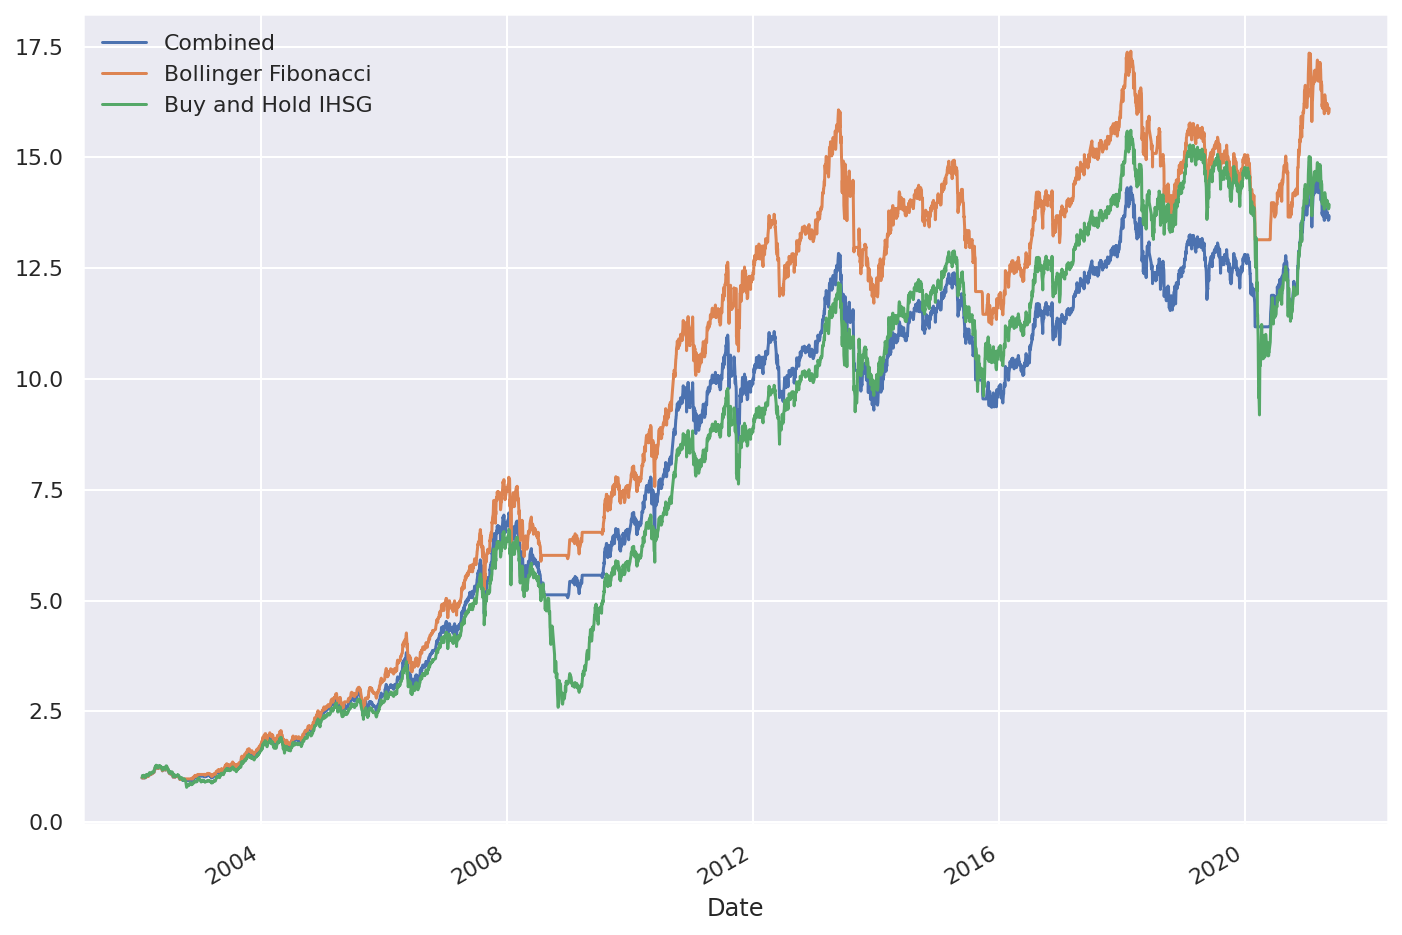

In [ ]:
import warnings
warnings.filterwarnings('ignore')

  # # Buy Boolean
  # [Bollinger_Buy_Up,Bollinger_Buy_Down,RSI_Buy_Over,RSI_Buy_Under,Fibonacci_Buy,MACD_Buy] = Buy
  # # Sell Boolean
  # [Bollinger_Sell_Up,Bollinger_Sell_Down,RSI_Sell_Over,RSI_Sell_Under,Fibonacci_Sell,MACD_Sell] = Sell
  # # ATR Boolean
  # [ATR_Entry,ATR_Exit] = ATR

#Combined
Portfolio_Performance_1 = Trade_Simulation(IHSG,[False,True,False,True,True,False],[True,False,True,False,True,False],[True,True],Regime_Entry=[2,3,4],Regime_Exit=[1])
Portfolio_Performance_1['Portfolio_Value'].plot(label='Combined')

# #Bollinger Only
# Portfolio_Performance_2 = Trade_Simulation(IHSG,True,False,False,False,True,False,False,False,True,Regime_Entry=[2,3,4],Regime_Exit=[1])
# Portfolio_Performance_2['Portfolio_Value'].plot(label='Bollinger')


# #Bollinger RSI
# Portfolio_Performance_3 = Trade_Simulation(IHSG,True,True,False,False,True,True,False,False,True,Regime_Entry=[2,3,4],Regime_Exit=[1])
# Portfolio_Performance_3['Portfolio_Value'].plot(label='Bollinger RSI')


#Bollinger Fibonacci
Portfolio_Performance_4 = Trade_Simulation(IHSG,[False,True,False,False,True,False],[True,False,False,False,True,False],[True,True],Regime_Entry=[2,3,4],Regime_Exit=[1])
Portfolio_Performance_4['Portfolio_Value'].plot(label='Bollinger Fibonacci')


# #RSI Only
# Portfolio_Performance_5 = Trade_Simulation(IHSG,False,True,False,False,False,True,False,False,True,Regime_Entry=[2,3,4],Regime_Exit=[1])
# Portfolio_Performance_5['Portfolio_Value'].plot(label='RSI')


# #RSI Fibonacci
# Portfolio_Performance_6 = Trade_Simulation(IHSG,False,True,True,False,False,True,True,False,True,Regime_Entry=[2,3,4],Regime_Exit=[1])
# Portfolio_Performance_6['Portfolio_Value'].plot(label='RSI Fibonacci')


(Portfolio_Performance_6['Adj Close'].pct_change() + 1).cumprod().plot(label='Buy and Hold IHSG')
plt.legend()
plt.show()

a = stat_Summary(Portfolio_Performance_1,"Combined")
# b = stat_Summary(Portfolio_Performance_2,"Bollinger")
# c = stat_Summary(Portfolio_Performance_3,"Bollinger RSI")
d = stat_Summary(Portfolio_Performance_4,"Bollinger FIbonacci")
# e = stat_Summary(Portfolio_Performance_5,"RSI")
# f = stat_Summary(Portfolio_Performance_6,"RSI Fibonacci")

from functools import reduce
# dfs = [a,b,c,d,e,f]
# df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
#                                               how='outer'), dfs)
# df_merged

In [ ]:
"""
  This line of code make the combinations of parameters, 
  here we will try to test many sorts of parameters and made sense of the performance
"""

Bollinger_Buy = [True, False]
RSI_Buy = [True, False]
Fibonacci_Buy = [True, False]
MACD_Buy = [True, False]
Bollinger_Sell = [True, False]
RSI_Sell = [True, False]
FIbonacci_Sell = [True, False]
MACD_Sell = [True, False]
ATR_Entry = [True, False]
ATR_Exit = [True, False]

import itertools
Regime_Entry = [1,2,3,4]
Regime_Exit = [1,2,3,4]

Regime_Entry_Comb = [list(itertools.combinations(Regime_Entry,r)) for r in range(1,5)]
Regime_Entry_Comb = [item for sublist in Regime_Entry_Comb for item in sublist]

Regime_Exit_Comb = [list(itertools.combinations(Regime_Exit,r)) for r in range(1,5)]
Regime_Exit_Comb = [item for sublist in Regime_Exit_Comb for item in sublist]

Bollinger_Day = [6,12,24]
Bollinger_Dev_Up = [1,1.5,2]
Bollinger_Dev_Down = [1,1.5,2]

Fibonacci_Day = [12,24,36,48]
MACD_Long_Day = [13,26,39]
MACD_Short_Day = [6,12,18]

RSI_Day = [6,12,18]
ATR_Day = [6,12,18]
RSI_Entry = [40,45,50]
RSI_Exit = [60,70,80]
ATR_Profit = [1,2,3]
ATR_Loss = [1,2,3]

print( " Number of Iterations")
print( 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 3 * 3 * 3 * 4 * 3 * 3 * 3 * 3 * 3 * 3 * 3 *3)

 Number of Iterations
725594112


In [ ]:
def Signal_Strength(df,Custom_Day=True):
  """
  Okay the number of iterations are 750 million...
  we will need another fitting strategy...

  To answer which parameter is best for buy and sell
  let's determine the average 5 10 20 days return before and after the buy and sell indicator

  This Functions runs on the backtest results as it requires entry and exit signal.
  This will produce days return before and after an entry or exit signal.
  """


  # Custom_Day = int(np.round(np.mean(np.diff(np.nonzero(a['Position'].diff().values)[0][1:])[::2])))
  B_5 = (1+ df[['Adj Close']].pct_change()).rolling(window=5).apply(np.prod, raw=True) - 1
  B_10 = (1+ df[['Adj Close']].pct_change()).rolling(window=10).apply(np.prod, raw=True) - 1
  B_20 = (1+ df[['Adj Close']].pct_change()).rolling(window=20).apply(np.prod, raw=True) - 1
  # B_C = (1+ df[['Adj Close']].pct_change()).rolling(window=Custom_Day).apply(np.prod, raw=True) - 1

  F_5 = (1+ df[['Adj Close']].pct_change())[::-1].rolling(window=5).apply(np.prod, raw=True) - 1
  F_10 = (1+ df[['Adj Close']].pct_change())[::-1].rolling(window=10).apply(np.prod, raw=True) - 1
  F_20 = (1+ df[['Adj Close']].pct_change())[::-1].rolling(window=20).apply(np.prod, raw=True) - 1
  # F_C = (1+ df[['Adj Close']].pct_change())[::-1].rolling(window=Custom_Day).apply(np.prod, raw=True) - 1

  dfs = [B_5,B_10,B_20,F_5,F_10,F_20]
  df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
                                                how='outer'), dfs)

  Entry_Signal_strength = df_merged[ (df['Entry'].values ==1)].mean(axis=0).to_frame()
  Entry_Signal_strength.index = ["E_B_5","E_B_10","E_B_20","E_F_5","E_F_10","E_F_20"]
  Entry_Signal_strength.columns = ["Return"]


  Exit_Signal_strength = df_merged[(df['Exit'].values ==1) ].mean(axis=0).to_frame()
  Exit_Signal_strength.index = ["Ex_B_5","Ex_B_10","Ex_B_20","Ex_F_5","Ex_F_10","Ex_F_20"]
  Exit_Signal_strength.columns = ["Return"]
  Exit_Signal_strength

  # figure, axes = plt.subplots(nrows=2, ncols=2)

  # axes[0, 0].plot(Entry_Signal_strength[0:3])
  # axes[0, 1].plot(Entry_Signal_strength[3:6])
  # axes[1, 0].plot(Exit_Signal_strength[0:3])
  # axes[1, 1].plot(Exit_Signal_strength[3:6])

  # axes[0, 0].set_title("Entry Backward")
  # axes[0, 1].set_title("Entry Forward")
  # axes[1, 0].set_title("Exit Backward")
  # axes[1, 1].set_title("Exit Forward")

  # figure.tight_layout()
  # plt.show()
  Signal_Strength = Entry_Signal_strength.append(Exit_Signal_strength)
  return Signal_Strength

In [ ]:
  # # Buy Boolean
  # [Bollinger_Buy_Up,Bollinger_Buy_Down,RSI_Buy_Over,RSI_Buy_Under,Fibonacci_Buy,MACD_Buy] = Buy
  # # Sell Boolean
  # [Bollinger_Sell_Up,Bollinger_Sell_Down,RSI_Sell_Over,RSI_Sell_Under,Fibonacci_Sell,MACD_Sell] = Sell
  # # ATR Boolean
  # [ATR_Entry,ATR_Exit] = ATR

Bollinger_Day = [6,12,24]
Bollinger_Dev_Up = [1,1.5,2]
Bollinger_Dev_Down = [1,1.5,2]

element = [x for x in itertools.product(*[Bollinger_Day,Bollinger_Dev_Up,Bollinger_Dev_Down])]
print(element)
import warnings
warnings.filterwarnings('ignore')
# Bollinger Fitting Maximising Sharpe
from functools import reduce
dfs = [Signal_Strength(Trade_Simulation(IHSG,[False,True,False,False,False,False],[True,False,False,False,False,False],[False,False],Bollinger_Day=x[0],Bollinger_Dev_Up=x[1],Bollinger_Dev_Down=x[2])) for x in element]
df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
                                              how='outer'), dfs)
# bollinger number 6 is the results [24 days and 1 std]

[(6, 1, 1), (6, 1, 1.5), (6, 1, 2), (6, 1.5, 1), (6, 1.5, 1.5), (6, 1.5, 2), (6, 2, 1), (6, 2, 1.5), (6, 2, 2), (12, 1, 1), (12, 1, 1.5), (12, 1, 2), (12, 1.5, 1), (12, 1.5, 1.5), (12, 1.5, 2), (12, 2, 1), (12, 2, 1.5), (12, 2, 2), (24, 1, 1), (24, 1, 1.5), (24, 1, 2), (24, 1.5, 1), (24, 1.5, 1.5), (24, 1.5, 2), (24, 2, 1), (24, 2, 1.5), (24, 2, 2)]


In [ ]:
"""

"""
Best_Entry = np.argmax(df_merged[3:6].max())

Best_Exit = np.argmin(df_merged[9:12].min())
print(Best_Entry,Best_Exit)


#Best Parameter

Best_Entry_Parameter = element[Best_Entry][0:3]
Best_Exit_Parameter = element[Best_Exit][0:3]
print(Best_Entry_Parameter,Best_Exit_Parameter)
df_merged.iloc[:,Best_Entry]
df_merged.iloc[:,Best_Exit]
# df_merged

0 0
(6, 1, 1) (6, 1, 1)


,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return_x,Return_y,Return
E_B_5,-0.028668,-0.032408,-0.037799,-0.028668,-0.032408,-0.037799,-0.028668,-0.032408,-0.037799,-0.026424,-0.041709,-0.049107,-0.026424,-0.041709,-0.049107,-0.026424,-0.041709,-0.049107,-0.022616,-0.036181,-0.049858,-0.022616,-0.036181,-0.049858,-0.022616,-0.036181,-0.049858
E_B_10,-0.024323,-0.028327,-0.018400,-0.024323,-0.028327,-0.018400,-0.024323,-0.028327,-0.018400,-0.031088,-0.046614,-0.049944,-0.031088,-0.046614,-0.049944,-0.031088,-0.046614,-0.049944,-0.028230,-0.047765,-0.060959,-0.028230,-0.047765,-0.060959,-0.028230,-0.047765,-0.060959
E_B_20,-0.020132,-0.024827,-0.051163,-0.020132,-0.024827,-0.051163,-0.020132,-0.024827,-0.051163,-0.025304,-0.042539,-0.045080,-0.025304,-0.042539,-0.045080,-0.025304,-0.042539,-0.045080,-0.034559,-0.054668,-0.063030,-0.034559,-0.054668,-0.063030,-0.034559,-0.054668,-0.063030
E_F_5,-0.012686,-0.017936,-0.041695,-0.012686,-0.017936,-0.041695,-0.012686,-0.017936,-0.041695,-0.017168,-0.016753,-0.018469,-0.017168,-0.016753,-0.018469,-0.017168,-0.016753,-0.018469,-0.020431,-0.023826,-0.020777,-0.020431,-0.023826,-0.020777,-0.020431,-0.023826,-0.020777
E_F_10,-0.008043,-0.014198,-0.047119,-0.008043,-0.014198,-0.047119,-0.008043,-0.014198,-0.047119,-0.014898,-0.012703,-0.018237,-0.014898,-0.012703,-0.018237,-0.014898,-0.012703,-0.018237,-0.018544,-0.017883,-0.018639,-0.018544,-0.017883,-0.018639,-0.018544,-0.017883,-0.018639
E_F_20,-0.003975,-0.012058,-0.049790,-0.003975,-0.012058,-0.049790,-0.003975,-0.012058,-0.049790,-0.010262,-0.008291,-0.013750,-0.010262,-0.008291,-0.013750,-0.010262,-0.008291,-0.013750,-0.016710,-0.017919,-0.011757,-0.016710,-0.017919,-0.011757,-0.016710,-0.017919,-0.011757
Ex_B_5,0.025173,0.025173,0.025173,0.027270,0.027270,0.027270,0.051671,0.051671,0.051671,0.020938,0.020938,0.020938,0.031701,0.031701,0.031701,0.038949,0.038949,0.038949,0.014842,0.014842,0.014842,0.024343,0.024343,0.024343,0.037026,0.037026,0.037026
Ex_B_10,0.029297,0.029297,0.029297,0.032435,0.032435,0.032435,0.103898,0.103898,0.103898,0.030298,0.030298,0.030298,0.040054,0.040054,0.040054,0.043183,0.043183,0.043183,0.023130,0.023130,0.023130,0.037072,0.037072,0.037072,0.050955,0.050955,0.050955
Ex_B_20,0.038159,0.038159,0.038159,0.040971,0.040971,0.040971,0.145288,0.145288,0.145288,0.039914,0.039914,0.039914,0.052183,0.052183,0.052183,0.058579,0.058579,0.058579,0.038108,0.038108,0.038108,0.056849,0.056849,0.056849,0.063785,0.063785,0.063785
Ex_F_5,0.014291,0.014291,0.014291,0.021013,0.021013,0.021013,0.032199,0.032199,0.032199,0.015999,0.015999,0.015999,0.015962,0.015962,0.015962,0.022214,0.022214,0.022214,0.016537,0.016537,0.016537,0.016298,0.016298,0.016298,0.017560,0.017560,0.017560


In [ ]:
  # # Buy Boolean
  # [Bollinger_Buy_Up,Bollinger_Buy_Down,RSI_Buy_Over,RSI_Buy_Under,Fibonacci_Buy,MACD_Buy] = Buy
  # # Sell Boolean
  # [Bollinger_Sell_Up,Bollinger_Sell_Down,RSI_Sell_Over,RSI_Sell_Under,Fibonacci_Sell,MACD_Sell] = Sell
  # # ATR Boolean
  # [ATR_Entry,ATR_Exit] = ATR

Bollinger_Day = [6,12,24]
Bollinger_Dev_Up = [1,1.5,2]
Bollinger_Dev_Down = [1,1.5,2]

element = [x for x in itertools.product(*[Bollinger_Day,Bollinger_Dev_Up,Bollinger_Dev_Down])]
print(element)
import warnings
warnings.filterwarnings('ignore')
# Bollinger Fitting Maximising Sharpe
from functools import reduce
dfs = [Signal_Strength(Trade_Simulation(IHSG,[True,False,False,False,False,False],[False,True,False,False,False,False],[False,False],Bollinger_Day=x[0],Bollinger_Dev_Up=x[1],Bollinger_Dev_Down=x[2])) for x in element]
df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
                                              how='outer'), dfs)
# bollinger number 6 is the results [24 days and 1 std]

[(6, 1, 1), (6, 1, 1.5), (6, 1, 2), (6, 1.5, 1), (6, 1.5, 1.5), (6, 1.5, 2), (6, 2, 1), (6, 2, 1.5), (6, 2, 2), (12, 1, 1), (12, 1, 1.5), (12, 1, 2), (12, 1.5, 1), (12, 1.5, 1.5), (12, 1.5, 2), (12, 2, 1), (12, 2, 1.5), (12, 2, 2), (24, 1, 1), (24, 1, 1.5), (24, 1, 2), (24, 1.5, 1), (24, 1.5, 1.5), (24, 1.5, 2), (24, 2, 1), (24, 2, 1.5), (24, 2, 2)]


In [ ]:
"""
Bollinger does not work here. since the entry signals mostly generate negative forward return and exit signals will generate good return.

So! Lets swap :), Alrite I swapped the bollinger, now we use up to buy and down to sell instead of the other way around, it may be wise next to give the option to use which bollnger to buy and sell.

Okay let's hope this one does not overfit.
"""
Best_Entry = np.argmax(df_merged[3:6].max())

Best_Exit = np.argmin(df_merged[9:12].min())
print(Best_Entry,Best_Exit)


#Best Parameter

Best_Entry_Parameter = element[Best_Entry][0:3]
Best_Exit_Parameter = element[Best_Exit][0:3]
print(Best_Entry_Parameter,Best_Exit_Parameter)
# df_merged.iloc[:,Best_Entry]
# df_merged.iloc[:,Best_Exit]

15 2
(12, 2, 1) (6, 1, 2)


In [ ]:
RSI_Day = [6,12,18]
RSI_Entry = [30,40,45,50]
RSI_Exit = [60,70,80]


element = [x for x in itertools.product(*[RSI_Day,RSI_Entry,RSI_Exit])]
print(element)
import warnings
warnings.filterwarnings('ignore')
# Bollinger Fitting Maximising Sharpe
from functools import reduce
dfs = [Signal_Strength(Trade_Simulation(IHSG,[False,False,False,True,False,False],[False,False,True,False,False,False],[False,False],RSI_Day=x[0],RSI_Entry=x[1],RSI_Exit=x[2])) for x in element]
df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
                                              how='outer'), dfs)
# bollinger number 6 is the results [24 days and 1 std]

[(6, 30, 60), (6, 30, 70), (6, 30, 80), (6, 40, 60), (6, 40, 70), (6, 40, 80), (6, 45, 60), (6, 45, 70), (6, 45, 80), (6, 50, 60), (6, 50, 70), (6, 50, 80), (12, 30, 60), (12, 30, 70), (12, 30, 80), (12, 40, 60), (12, 40, 70), (12, 40, 80), (12, 45, 60), (12, 45, 70), (12, 45, 80), (12, 50, 60), (12, 50, 70), (12, 50, 80), (18, 30, 60), (18, 30, 70), (18, 30, 80), (18, 40, 60), (18, 40, 70), (18, 40, 80), (18, 45, 60), (18, 45, 70), (18, 45, 80), (18, 50, 60), (18, 50, 70), (18, 50, 80)]


In [ ]:
"""
Time for RSI

Apparently RSI also does not work here. since the entry signals mostly generate negative forward return and exit signals will generate good return.

It is weird that bollinger and RSI dont actually work for the next 20 days... 

BUt Anyway, first we assumme RSI OVer and underbrought for sell and buy
"""
Best_Entry = np.argmax(df_merged[3:6].max())

Best_Exit = np.argmin(df_merged[9:12].min())
print(element)
print(Best_Entry,Best_Exit)
df_merged

# #Best Parameter

Best_Entry_Parameter = element[Best_Entry][0:3]
Best_Exit_Parameter = element[Best_Exit][0:3]
print(Best_Entry_Parameter,Best_Exit_Parameter)
# df_merged.iloc[:,Best_Entry]
# df_merged.iloc[:,Best_Exit]
# df_merged

[(6, 30, 60), (6, 30, 70), (6, 30, 80), (6, 40, 60), (6, 40, 70), (6, 40, 80), (6, 45, 60), (6, 45, 70), (6, 45, 80), (6, 50, 60), (6, 50, 70), (6, 50, 80), (12, 30, 60), (12, 30, 70), (12, 30, 80), (12, 40, 60), (12, 40, 70), (12, 40, 80), (12, 45, 60), (12, 45, 70), (12, 45, 80), (12, 50, 60), (12, 50, 70), (12, 50, 80), (18, 30, 60), (18, 30, 70), (18, 30, 80), (18, 40, 60), (18, 40, 70), (18, 40, 80), (18, 45, 60), (18, 45, 70), (18, 45, 80), (18, 50, 60), (18, 50, 70), (18, 50, 80)]
9 24
(6, 50, 60) (18, 30, 60)


In [ ]:
RSI_Day = [6,12,18]
RSI_Entry = [30,40,45,50]
RSI_Exit = [60,70,80]


element = [x for x in itertools.product(*[RSI_Day,RSI_Entry,RSI_Exit])]
print(element)
import warnings
warnings.filterwarnings('ignore')
# Bollinger Fitting Maximising Sharpe
from functools import reduce
dfs = [Signal_Strength(Trade_Simulation(IHSG,[False,False,True,False,False,False],[False,False,False,True,False,False],[False,False],RSI_Day=x[0],RSI_Entry=x[1],RSI_Exit=x[2])) for x in element]
df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
                                              how='outer'), dfs)
# bollinger number 6 is the results [24 days and 1 std]

[(6, 30, 60), (6, 30, 70), (6, 30, 80), (6, 40, 60), (6, 40, 70), (6, 40, 80), (6, 45, 60), (6, 45, 70), (6, 45, 80), (6, 50, 60), (6, 50, 70), (6, 50, 80), (12, 30, 60), (12, 30, 70), (12, 30, 80), (12, 40, 60), (12, 40, 70), (12, 40, 80), (12, 45, 60), (12, 45, 70), (12, 45, 80), (12, 50, 60), (12, 50, 70), (12, 50, 80), (18, 30, 60), (18, 30, 70), (18, 30, 80), (18, 40, 60), (18, 40, 70), (18, 40, 80), (18, 45, 60), (18, 45, 70), (18, 45, 80), (18, 50, 60), (18, 50, 70), (18, 50, 80)]


In [ ]:
"""
Time for RSI

Apparently RSI also does not work here. since the entry signals mostly generate negative forward return and exit signals will generate good return.

It is weird that bollinger and RSI dont actually work for the next 20 days... 

BUt Anyway, first we assumme RSI OVer and underbrought for sell and buy
"""
Best_Entry = np.argmax(df_merged[3:6].max())

Best_Exit = np.argmin(df_merged[9:12].min())
print(element)
print(Best_Entry,Best_Exit)
df_merged

# #Best Parameter

Best_Entry_Parameter = element[Best_Entry][0:3]
Best_Exit_Parameter = element[Best_Exit][0:3]
print(Best_Entry_Parameter,Best_Exit_Parameter)
# df_merged.iloc[:,Best_Entry]
# df_merged.iloc[:,Best_Exit]
# df_merged

[(6, 30, 60), (6, 30, 70), (6, 30, 80), (6, 40, 60), (6, 40, 70), (6, 40, 80), (6, 45, 60), (6, 45, 70), (6, 45, 80), (6, 50, 60), (6, 50, 70), (6, 50, 80), (12, 30, 60), (12, 30, 70), (12, 30, 80), (12, 40, 60), (12, 40, 70), (12, 40, 80), (12, 45, 60), (12, 45, 70), (12, 45, 80), (12, 50, 60), (12, 50, 70), (12, 50, 80), (18, 30, 60), (18, 30, 70), (18, 30, 80), (18, 40, 60), (18, 40, 70), (18, 40, 80), (18, 45, 60), (18, 45, 70), (18, 45, 80), (18, 50, 60), (18, 50, 70), (18, 50, 80)]
33 0
(18, 50, 60) (6, 30, 60)


6
6
6
12
12


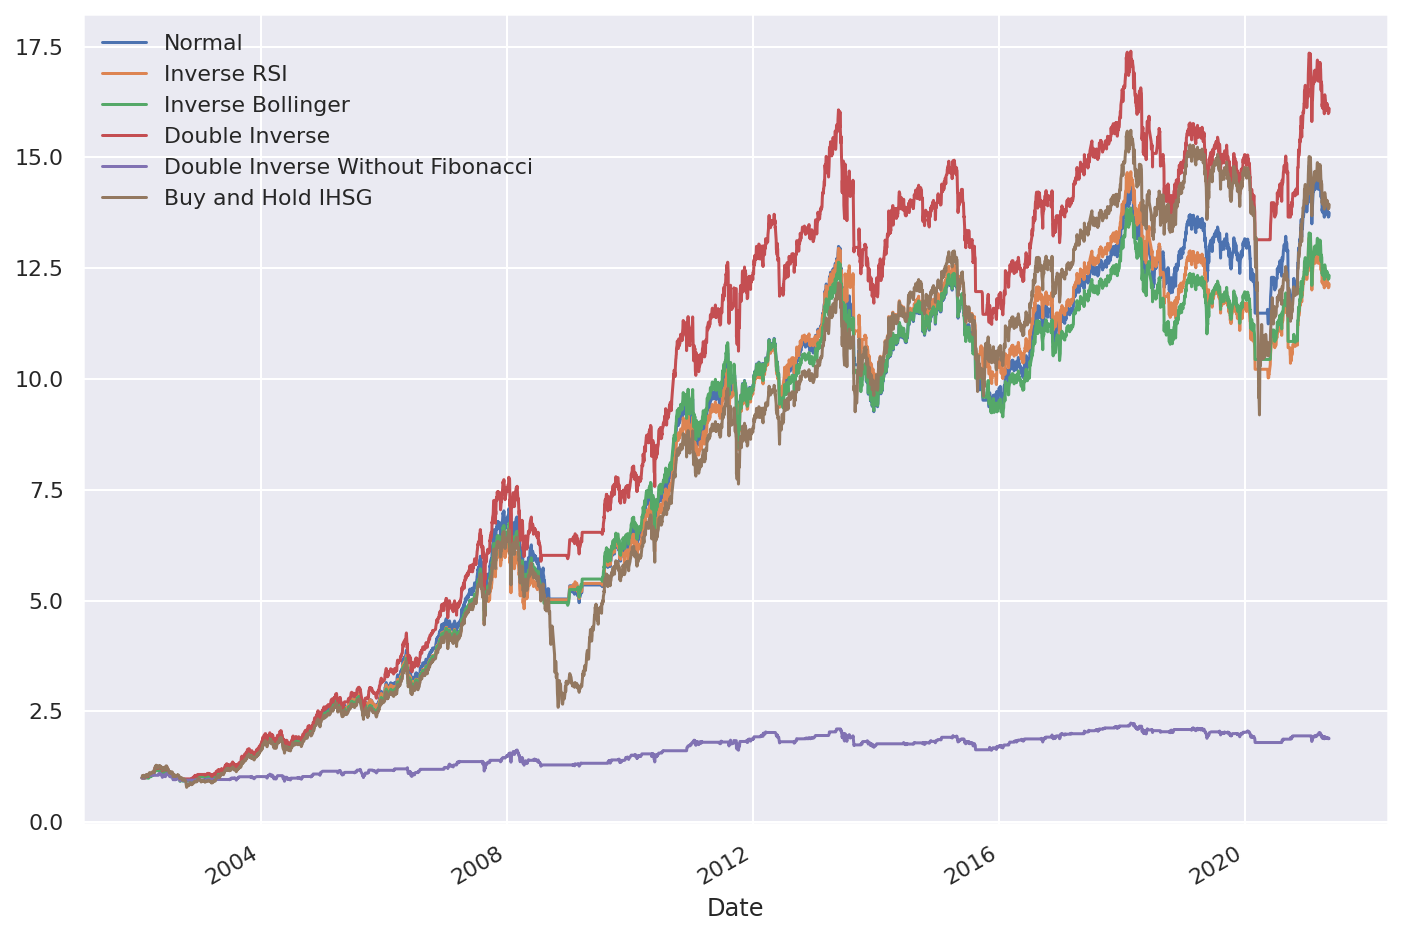

,Normal,Inveres RSI,Inverse Bollinger,Double Inverse,Double Inverse Without Fibonacci
Total_Profit,12.676342,11.078421,11.270056,15.013994,0.886255
CAGR,0.150761,0.143111,0.144077,0.160551,0.034655
Tracking_Error,0.112368,0.119853,0.116384,0.116914,0.164146
Return_Performance,-0.000716,-0.007359,-0.006520,0.007786,-0.101538
Information Ratio,-0.006368,-0.061399,-0.056018,0.066593,-0.618585
Sharpe Portfolio,56.766059,53.956888,53.822040,63.398401,-11.690831
Sharpe Index,48.364941,48.364941,48.364941,48.364941,48.364941
Win_Rate,0.918919,0.978261,0.956522,0.976190,0.937500
Total_Trade,37.000000,92.000000,23.000000,42.000000,96.000000
Max_Losing_Streak,2.000000,2.000000,2.000000,2.000000,2.000000


In [ ]:
import warnings
warnings.filterwarnings('ignore')

  # # Buy Boolean
  # [Bollinger_Buy_Up,Bollinger_Buy_Down,RSI_Buy_Over,RSI_Buy_Under,Fibonacci_Buy,MACD_Buy] = Buy
  # # Sell Boolean
  # [Bollinger_Sell_Up,Bollinger_Sell_Down,RSI_Sell_Over,RSI_Sell_Under,Fibonacci_Sell,MACD_Sell] = Sell
  # # ATR Boolean
  # [ATR_Entry,ATR_Exit] = ATR

#Normal BOllinger Parameter (6, 1, 1)
#Inverse Bollinger Parameter (12, 2, 1) (6, 1, 2)
#Normal RSI (6, 50, 60) (18, 30, 60)
#Inverse RSI (18, 50, 60) (6, 30, 60)


#Bollinger RSI Normal
# Bollinger_Day = 6,Bollinger_Dev_Up = 1, Bollinger_Dev_Down = 1, RSI_Day = 6, RSI_Entry = 50, RSI_Exit = 60

Portfolio_Performance_1 = Trade_Simulation(IHSG,[False,True,False,True,True,False],[True,False,True,False,True,False],[True,True],Regime_Entry=[2,3,4],Regime_Exit=[1],
                                           Bollinger_Day_Up = 6,Bollinger_Day_Down = 6,Bollinger_Dev_Up = 1, Bollinger_Dev_Down = 1, RSI_Day = 18, RSI_Entry = 50, RSI_Exit = 60)
Portfolio_Performance_1['Portfolio_Value'].plot(label='Normal')

#Bollinger Normal RSI Inverse
# Bollinger_Day = 6,Bollinger_Dev_Up = 1, Bollinger_Dev_Down = 1, RSI_Day = 18, RSI_Entry = 50, RSI_Exit = 60

Portfolio_Performance_2 = Trade_Simulation(IHSG,[False,True,False,False,True,False],[True,False,False,False,True,False],[True,True],Regime_Entry=[2,3,4],Regime_Exit=[1],
                                           Bollinger_Day_Up = 6,Bollinger_Day_Down = 6,Bollinger_Dev_Up = 1, Bollinger_Dev_Down = 1, RSI_Day = 18, RSI_Entry = 50, RSI_Exit = 60)
Portfolio_Performance_2['Portfolio_Value'].plot(label='Inverse RSI')

#Bollinger Inverse RSI Normal
# Bollinger_Day = 12,Bollinger_Dev_Up = 2, Bollinger_Dev_Down = 2, RSI_Day = 6, RSI_Entry = 50, RSI_Exit = 60

Portfolio_Performance_3 = Trade_Simulation(IHSG,[False,True,False,False,True,False],[True,False,False,False,True,False],[True,True],Regime_Entry=[2,3,4],Regime_Exit=[1],
                                           Bollinger_Day_Up = 12,Bollinger_Day_Down = 6,Bollinger_Dev_Up = 2, Bollinger_Dev_Down = 2, RSI_Day = 6, RSI_Entry = 50, RSI_Exit = 60)
Portfolio_Performance_3['Portfolio_Value'].plot(label='Inverse Bollinger')

#Bollinger  RSI Inverse
# Bollinger_Day = 12,Bollinger_Dev_Up = 2, Bollinger_Dev_Down = 2, RSI_Day = 18, RSI_Entry = 50, RSI_Exit = 60

Portfolio_Performance_4 = Trade_Simulation(IHSG,[False,True,False,False,True,False],[True,False,False,False,True,False],[True,True],Regime_Entry=[3,2,4],Regime_Exit=[1],
                                           Bollinger_Day_Up = 12,Bollinger_Day_Down = 12,Bollinger_Dev_Up = 1.5, Bollinger_Dev_Down = 1.5, RSI_Day = 24, RSI_Entry = 30, RSI_Exit = 70)
Portfolio_Performance_4['Portfolio_Value'].plot(label='Double Inverse')

# Bollinger RSI Inverse
# Bollinger_Day = 12,Bollinger_Dev_Up = 2, Bollinger_Dev_Down = 2, RSI_Day = 18, RSI_Entry = 50, RSI_Exit = 60

Portfolio_Performance_5 = Trade_Simulation(IHSG,[False,True,False,False,False,False],[True,False,False,False,False,False],[True,True],Regime_Entry=[3,2,4],Regime_Exit=[1],
                                           Bollinger_Day_Up = 12,Bollinger_Day_Down = 12,Bollinger_Dev_Up = 1.5, Bollinger_Dev_Down = 1.5, RSI_Day = 24, RSI_Entry = 30, RSI_Exit = 70)
Portfolio_Performance_5['Portfolio_Value'].plot(label='Double Inverse Without Fibonacci')



(Portfolio_Performance_1['Adj Close'].pct_change() + 1).cumprod().plot(label='Buy and Hold IHSG')
plt.legend()
plt.show()

a = stat_Summary(Portfolio_Performance_1,"Normal")
b = stat_Summary(Portfolio_Performance_2,"Inveres RSI")
c = stat_Summary(Portfolio_Performance_3,"Inverse Bollinger")
d = stat_Summary(Portfolio_Performance_4,"Double Inverse")
e = stat_Summary(Portfolio_Performance_5,"Double Inverse Without Fibonacci")

from functools import reduce
dfs = [a,b,c,d,e]
df_merged = reduce(lambda  left,right: pd.merge(left,right,right_index=True,left_index=True,
                                              how='outer'), dfs)
df_merged

OKay so fitting the parameters this way wont work.

We need to find something else now...

Let's start writing the paper instead....

But during this exercise we found that using the bearish and high variance regime to stop our position helps!.

The trading indicator however... only helps when the trade is lesser and lesser. and the drawdown lengths are crazy long.

As for the paper that we read, the big PL is gotten from dividing the bullish and bearish regimes. and then playing long and short...

so what is next...
